# EDA of Aiming Dataset

Here we focus on how the arm's transport kinematics change with distance

In [2]:
from os import linesep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from matplotlib.lines import lineStyles
from scipy import stats
from scipy.ndimage import label
from sklearn.externals.array_api_extra import nunique
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load the dataset
df = pd.read_csv("C:/CourseWork/Dissertation Classifying grip strategies using machine learning/data/02_processed/aiming_master_dataset.csv")
print("Successfully loaded the dataset")

Successfully loaded the dataset


## Setup and Initial Data Inspection

In [4]:
# Initial Inspection
print("\n--- Initial Data Inspection ---")
print(f"Dataset Shape: {df.shape}")
print(f"Total Number of Missing values: {df.isnull().sum().sum()}")

df.head()


--- Initial Data Inspection ---
Dataset Shape: (2423, 213)
Total Number of Missing values: 0


subjName  trialN visCond surface distance         DOB  Gender Dominant.Eye  \
0         1       1   clear   black    three  28/03/2003  female         left   
1         1       2   clear   black      two  28/03/2003  female         left   
2         1       3   clear    wood    three  28/03/2003  female         left   
3         1       4   clear    wood      one  28/03/2003  female         left   
4         1       5   clear    wood      two  28/03/2003  female         left   

   clear.logMAR  mono.logMAR  ...  timeToYmax_index  timeToYmax_knuck  \
0         -0.06         0.02  ...          2.041667          2.058333   
1         -0.06         0.02  ...          2.175000          2.200000   
2         -0.06         0.02  ...          1.675000          1.683333   
3         -0.06         0.02  ...          1.700000          1.733333   
4         -0.06         0.02  ...          2.058333          2.083333   

   timeToYmax_target  timeToYmax_thumb  timeToYmax_wrist  timeToZmax_index  \
0           2.041667          2.041667          2.075000          2.758333   
1           2.175000          2.183333          2.225000          2.883333   
2           1.675000          1.675000          1.708333          2.600000   
3           1.700000          1.700000          1.775000          2.300000   
4           2.066667          2.075000          2.116667          2.775000   

   timeToZmax_knuck  timeToZmax_target  timeToZmax_thumb  timeToZmax_wrist  
0          2.816667           2.583333          2.608333          2.600000  
1          3.216667           2.858333          2.550000          2.500000  
2          2.625000           2.500000          2.466667          2.108333  
3          1.941667           1.933333          1.941667          1.941667  
4          2.841667           2.625000          2.641667          2.633333  

[5 rows x 213 columns]

## Step 2: Data Cleaning and Preprocessing

In [5]:
print("\n--- Starting Data Cleaning Preprocessing---")


--- Starting Data Cleaning Preprocessing---


In [6]:
# 1. Handle inconsistent Text Data
print("Original unique values in 'Gender':", df["Gender"].unique())
print("Original unique values in 'Dominant.Eye':", df["Dominant.Eye"].unique())

Original unique values in 'Gender': ['female' 'male' 'Female' 'Male']
Original unique values in 'Dominant.Eye': ['left' 'right' 'Left' 'Right']


In [7]:
# Fix it
df["Gender"] = df["Gender"].str.lower()
df["Dominant.Eye"] = df["Dominant.Eye"].str.lower()

print("Standardized unique values in 'Gender':", df["Gender"].nunique())
print("Standardized unique values in 'Dominant.Eye':",df["Dominant.Eye"].nunique())

Standardized unique values in 'Gender': 2
Standardized unique values in 'Dominant.Eye': 2


In [8]:
# 2. Correct Data Types and Create "Age" Feature
df["DOB"] = pd.to_datetime(df["DOB"], format="%d/%m/%Y", errors="coerce")
current_year = datetime.now().year
df["Age"] = df["DOB"].apply(lambda x: current_year - x.year)
print("Created 'Age' column from 'DOB' ")


# 1. Convert the 'DOB' column in the dataset to datetime format.
# 2. Get the current year.
# 3. For each row in the dataset:
#    a. Subtract the year of birth from the current year to calculate age.
#    b. Store the result in a new column called 'Age'.
# 4. Print confirmation that the 'Age' column has been created.
#


Created 'Age' column from 'DOB' 


In [9]:
# 3. Convert categorical columns to 'category' type for efficency
categorical_cols = ['subjName', 'visCond', 'surface', 'distance', 'Gender', 'Dominant.Eye']
for col in categorical_cols:
    df[col] = df[col].astype('category')
print("Converted categorical columns to 'category' dtype.")


# 1. Define a list of columns that contain categorical data.
# 2. For each column in the list:
#    a. Convert the column’s data type to 'category' for memory efficiency.
# 3. Print a message confirming the conversion.


Converted categorical columns to 'category' dtype.


In [10]:
# 4. Address Redundant Kinematic Columns
if "MVel_y" in df.columns and "MVel_x" in df.columns:
    df.rename(columns={"MVel_y": "PeakVelocity", "MGA_y": "MaxGripAperture"}, inplace=True)
    df.drop(columns=["MVel_x", "MGA_x"], inplace=True, errors="ignore")
    print("Renamed 'MVel_y' -> 'PeakVelocity', 'MGA_y' -> 'MaxGripAperture', and dropped redundant _x versions.")

# 1. Define a list of columns that contain categorical data.
# 2. For each column in the list:
#    a. Convert the column’s data type to 'category' for memory efficiency.
# 3. Print a message confirming the conversion.



Renamed 'MVel_y' -> 'PeakVelocity', 'MGA_y' -> 'MaxGripAperture', and dropped redundant _x versions.


In [11]:
# 5 Ordinal Encoding for "distance"
distance_mapping = {"one": 1, "two": 2, "three": 3}
if df["distance"].dtype == "category":
    df["distance_ordinal"] = df["distance"].cat.rename_categories(distance_mapping).astype(int)
    print(f"Created 'distance_ordinal' with mapping: {distance_mapping}")

print("\n--- Preprocessing Complete ---")

df.info(verbose=False)


# 1. Define a mapping from distance category names ("one", "two", "three") to ordinal values (1, 2, 3).
# 2. If the 'distance' column is of categorical type:
#    a. Rename the categories using the defined mapping.
#    b. Convert the result to integer type and store it in a new column called 'distance_ordinal'.
#    c. Print the mapping used.
# 3. Print a message indicating preprocessing is complete.
# 4. Display a summary of the DataFrame structure (without listing all columns).

Created 'distance_ordinal' with mapping: {'one': 1, 'two': 2, 'three': 3}

--- Preprocessing Complete ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2423 entries, 0 to 2422
Columns: 213 entries, subjName to distance_ordinal
dtypes: category(6), datetime64[ns](1), float64(195), int64(11)
memory usage: 3.8 MB


## Step 3: Univariate Analysis


 --- Analysing Categorical and Subject Variables ---


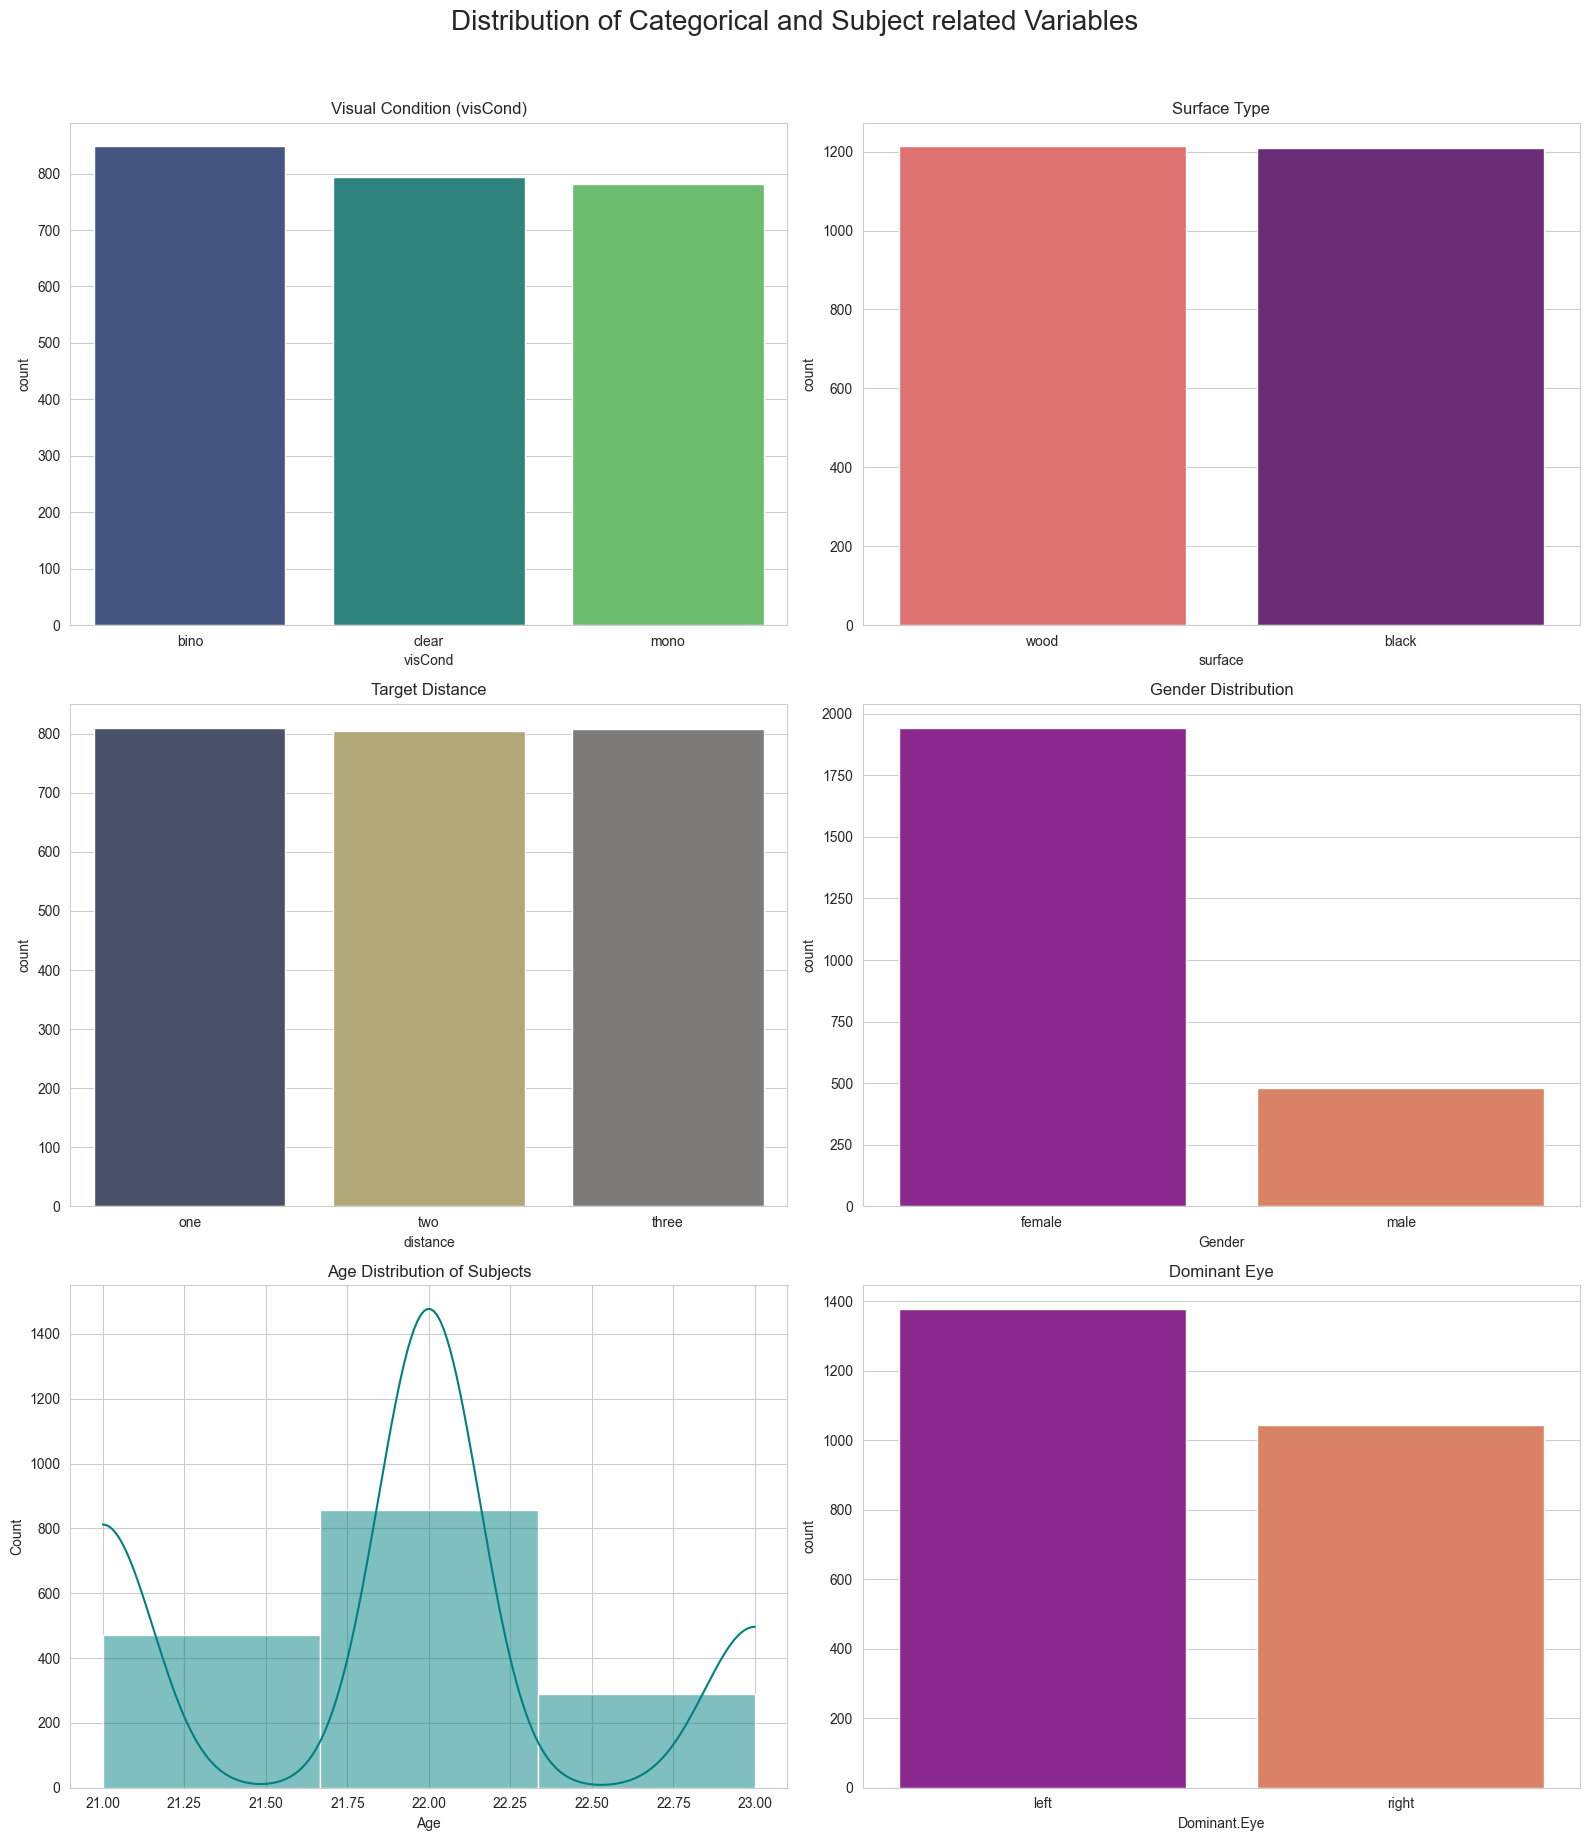

In [12]:
# 3.1 Distribution of Categorical and subject variables
import seaborn as sns
import matplotlib.pyplot as plt

print("\n --- Analysing Categorical and Subject Variables ---")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Distribution of Categorical and Subject related Variables", fontsize=20, y=1.02)

# 1. Visual Condition
sns.countplot(ax=axes[0, 0], x="visCond", data=df, hue="visCond", palette="viridis", legend=False,
              order=df["visCond"].value_counts().index)
axes[0, 0].set_title("Visual Condition (visCond)")

# 2. Surface Type
sns.countplot(ax=axes[0, 1], x="surface", data=df, hue="surface", palette="magma", legend=False,
              order=df["surface"].value_counts().index)
axes[0, 1].set_title("Surface Type")

# 3. Target Distance
sns.countplot(ax=axes[1, 0], x="distance", data=df, hue="distance", palette="cividis", legend=False,
              order=["one", "two", "three"])
axes[1, 0].set_title("Target Distance")

# 4. Gender Distribution
sns.countplot(ax=axes[1, 1], x="Gender", data=df, hue="Gender", palette="plasma", legend=False,
              order=df["Gender"].value_counts().index)
axes[1, 1].set_title("Gender Distribution")

# 5. Age Distribution
sns.histplot(ax=axes[2, 0], data=df, x="Age", bins=df["Age"].nunique(), kde=True, color="teal")
axes[2, 0].set_title("Age Distribution of Subjects")

# 6. Dominant Eye
sns.countplot(ax=axes[2, 1], x="Dominant.Eye", data=df, hue="Dominant.Eye", palette="plasma", legend=False,
              order=df["Dominant.Eye"].value_counts().index)
axes[2, 1].set_title("Dominant Eye")

plt.tight_layout()
plt.show()


# 1. Print a message indicating the start of categorical and subject variable analysis.
# 2. Create a 3x2 grid of subplots for displaying six plots, with a common figure title.
# 3. Plot the distribution of each variable:
#    a. Plot a count plot for 'visCond' (Visual Condition).
#    b. Plot a count plot for 'surface' (Surface Type).
#    c. Plot a count plot for 'distance' (Target Distance) in a fixed order.
#    d. Plot a count plot for 'Gender'.
#    e. Plot a histogram for 'Age' with a KDE line.
#    f. Plot a count plot for 'Dominant.Eye'.
# 4. Adjust layout for better spacing.
# 5. Display the plots.


**Visual Condition, Surface Type, Target Distance:** These three plots are the most important from an experimental design perspective. They all show bars of nearly equal height. This shows a well balanced dataset.

**Gender Distribution and Dominant Eye:** These plots describe the composition of the subject pool. The dataset consists of more female participants then males, and more left eye dominant participants than right eye dominant. Now since we are classifying movements strategies based on kinematics, not on the person performing this should't be an issue.

**Age Distribution of Subjects:** This histogram shows that the participants are from a homogeneous age group, concentrated around 22 years old. This is good because it reduces the potential for age to be a cofounding variable. The Kernel Density Estimate (KDE) curve is likely an artifact of having only a few distinct age values.



--- Analysing Distributions of Key Kinamatic Variables ---


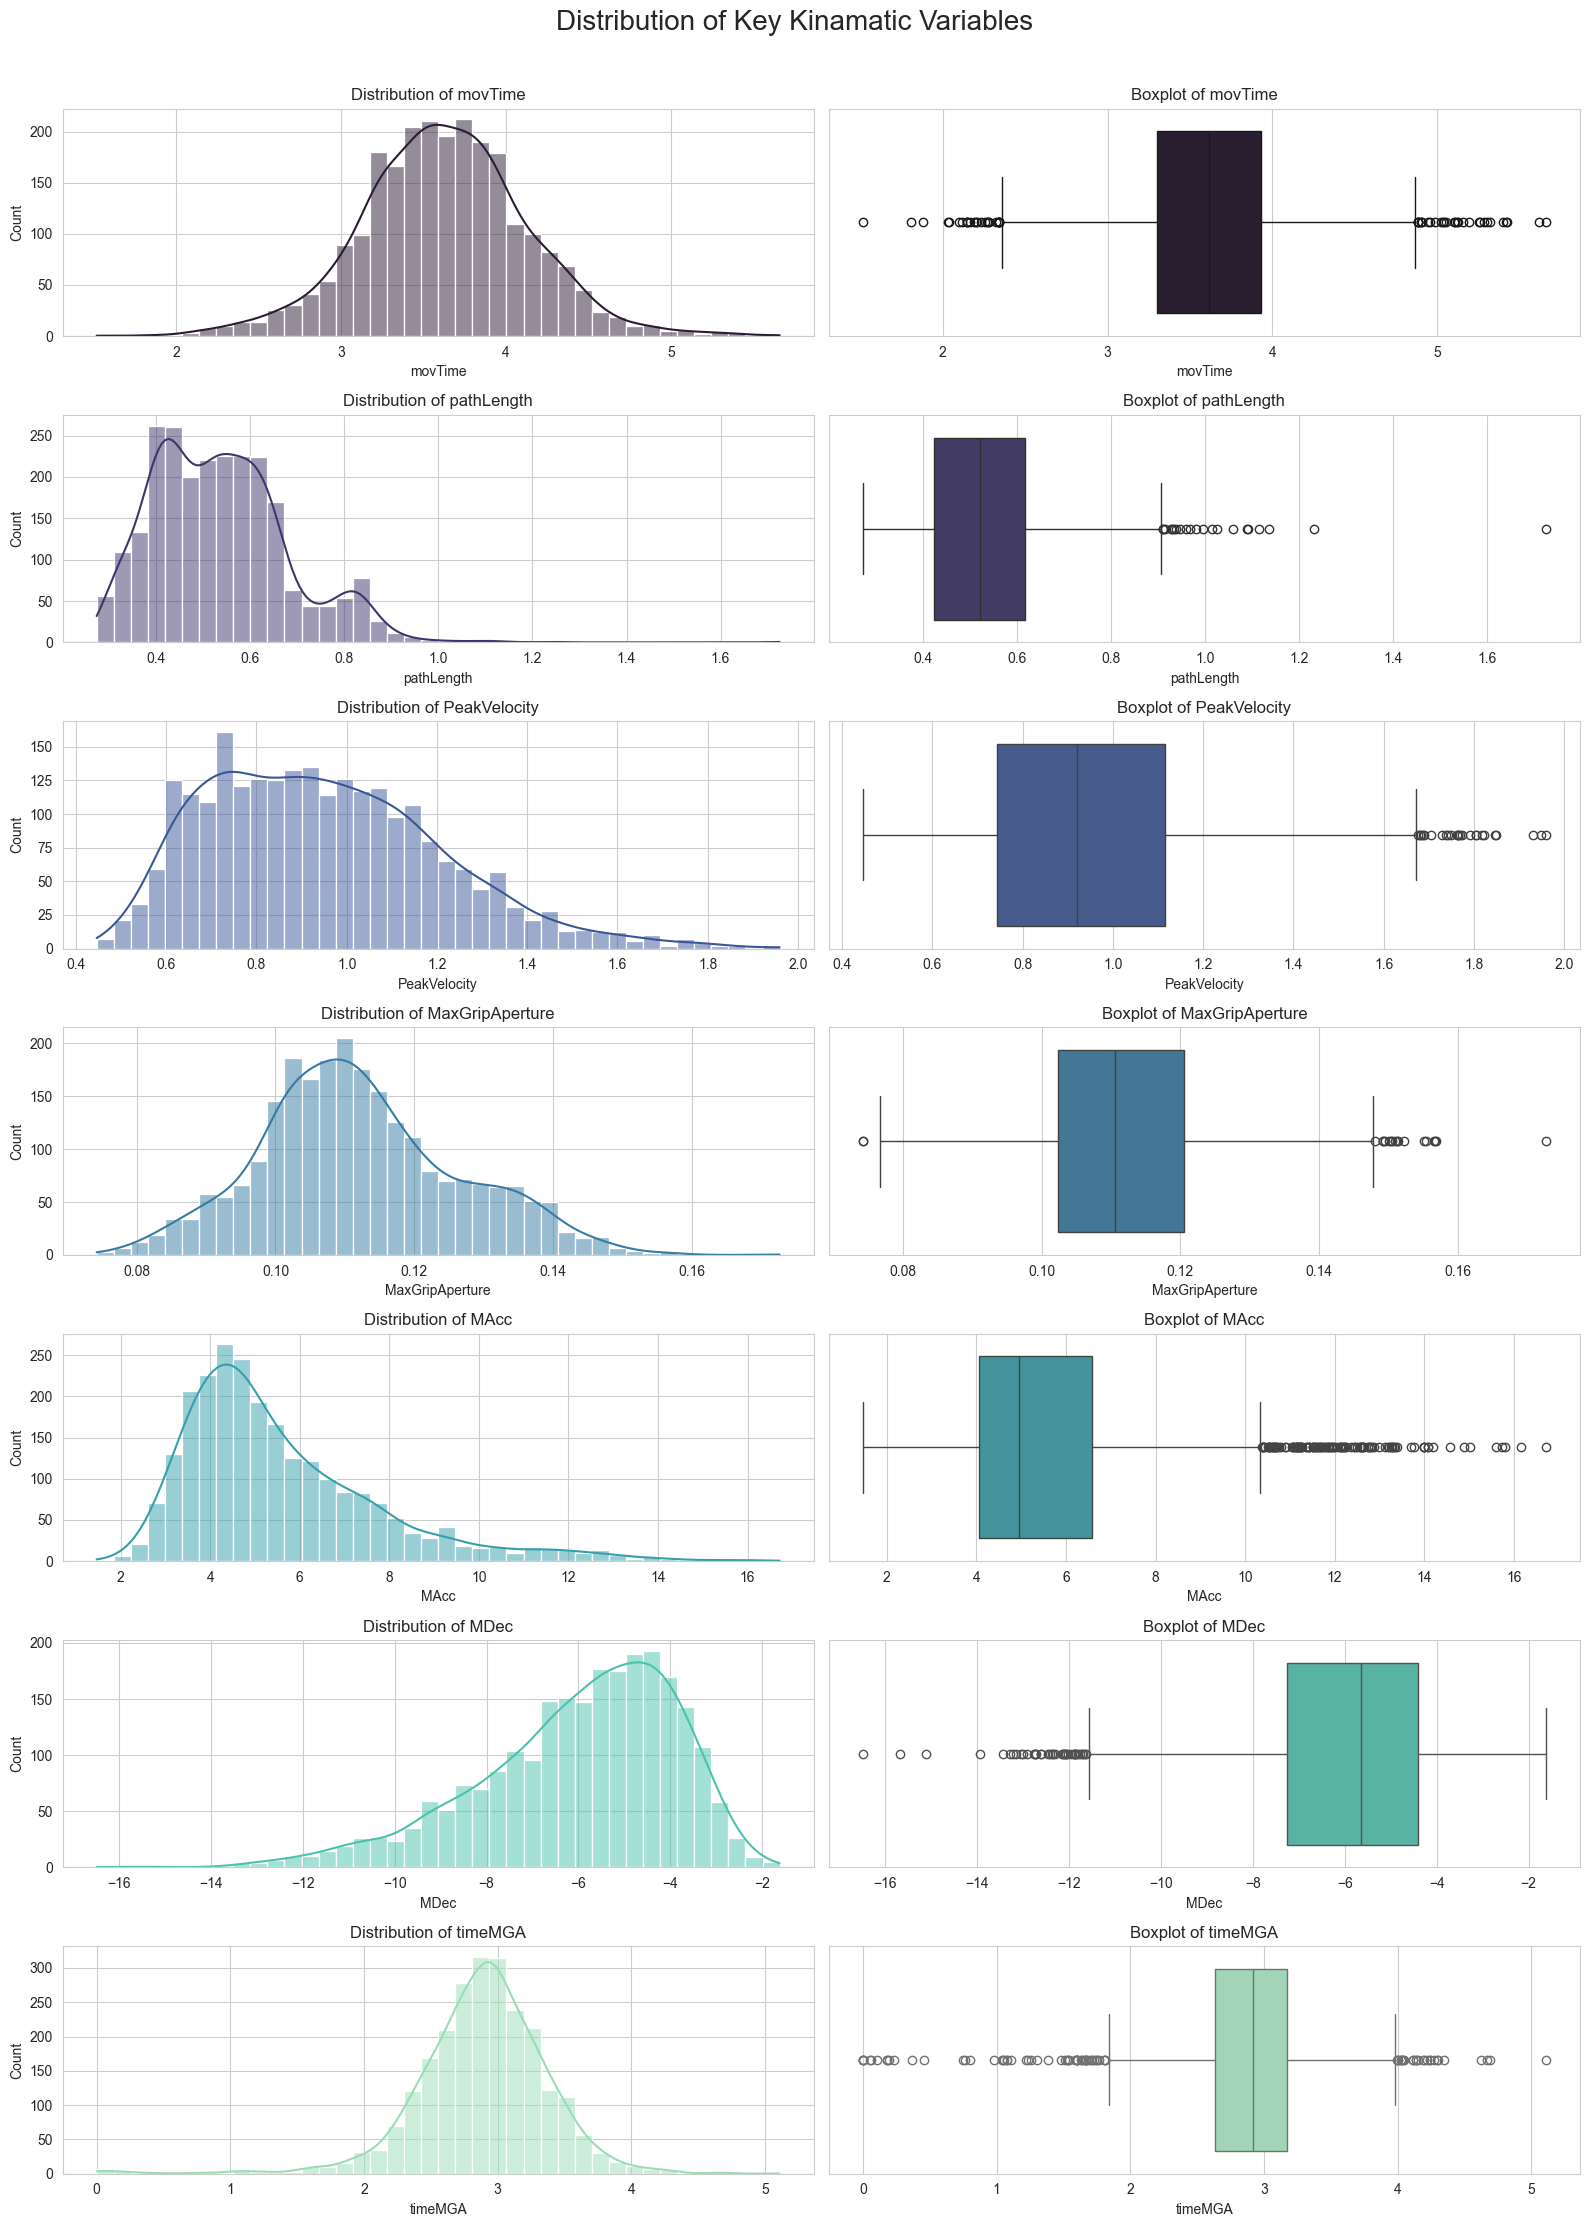

In [13]:
print("--- Analysing Distributions of Key Kinamatic Variables ---")

key_kinamatic_vars = ['movTime', 'pathLength', 'PeakVelocity', 'MaxGripAperture', 'MAcc', 'MDec', 'timeMGA']

fig, axes = plt.subplots(len(key_kinamatic_vars), 2, figsize=(16, 22))
plt.suptitle("Distribution of Key Kinamatic Variables", fontsize=20, y=1.01)

for i, var in enumerate(key_kinamatic_vars):
    if var in df.columns:
        # Histogram with KDE
        sns.histplot(ax=axes[i, 0], data=df, x=var, kde=True, bins=40,
                     color=sns.color_palette("mako", len(key_kinamatic_vars))[i])
        axes[i, 0].set_title(f"Distribution of {var}")

        # Boxplot to identify spread and outliers
        sns.boxplot(ax=axes[i, 1], data=df, x=var,
                    color=sns.color_palette("mako", len(key_kinamatic_vars))[i])
        axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()


# 1. Print a message indicating analysis of key kinematic variable distributions.
# 2. Define a list of key kinematic variables.
# 3. Create a grid of subplots with two columns (for histogram and boxplot) and as many rows as there are variables.
# 4. Set a common title for the entire figure.
#
# 5. For each variable in the list:
#    a. Check if the variable exists in the dataset.
#    b. Plot a histogram with a KDE curve to show the distribution of the variable.
#    c. Plot a boxplot to visualize the spread and detect outliers for the variable.
#
# 6. Adjust layout to prevent overlapping.
# 7. Display all plots.

* **Distribution of movTime and Distribution of pathLength:** Both the histograms are right skewed. This means that most movements were relatively quick and efficient, but there is a long tail of movements that took much longer or followed a less direct path. The boxplots confirm this, showing many outliers on the higher end.
* **Distribution of PeakVelocity and Distribution of MAcc:** These distributions are much more symmetric and resemble a normal (bell-shaped) curve. This suggests that while the duration of movements can very a lot, the peak speed and acceleration subjects use tend to fall within a more predictable range.
* **Distribution of MDec (Peak Deceleration):** This distribution is left skewed, which is the opposite of the acceleration plot. It represents the braking phase of the movement.
* **Distribution of MaxGripAperture and Distribution of timeMGA:** The maximum grip aperture and the time which this occus are both bell shaped and symmetric. This implies that subjects were very consistent in how they pre shaped their hand and when they achieved that maximum opening during the reach.

## Step 4: Bivariate and Multivariate Analysis


--- Correlation Matrix of Key Kinamatic Variables ---


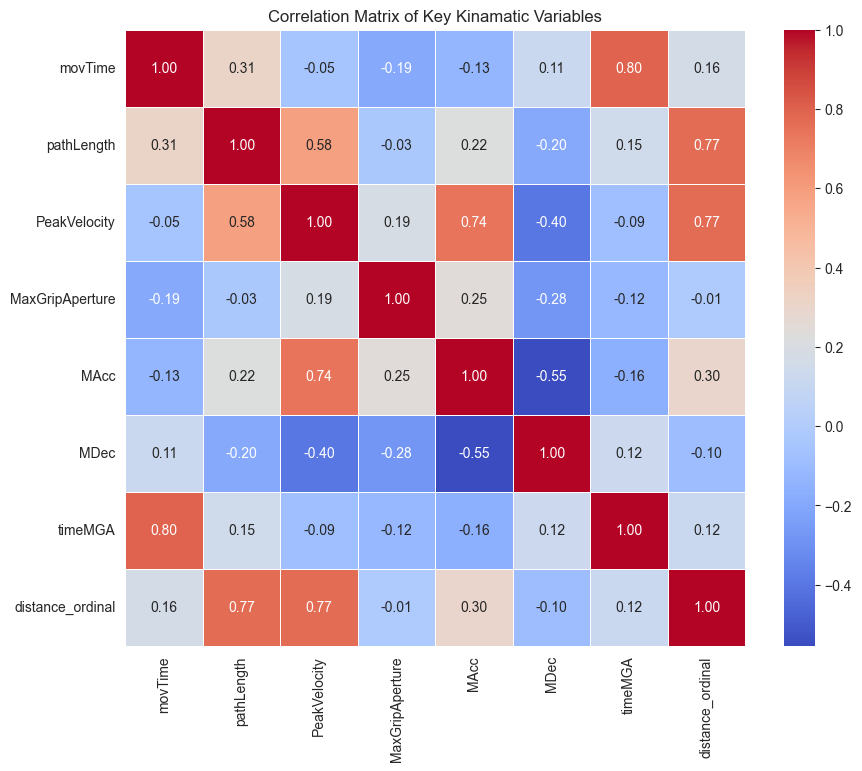

In [14]:
# 4.1 Correlation of Key Kinematic Variables
print("--- Correlation Matrix of Key Kinamatic Variables ---")

if all(v in df.columns for v in key_kinamatic_vars):
    corr_vars = key_kinamatic_vars + ["distance_ordinal"]
    corr_matrix = df[corr_vars].corr()

    plt.figure(figsize=[10, 8])
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix of Key Kinamatic Variables")
    plt.show()


# 1. Print a message indicating the analysis of correlations among key kinematic variables.
# 2. Check if all key kinematic variables exist in the dataset.
# 3. If they do:
#    a. Create a list of variables to include in the correlation (key kinematic variables + 'distance_ordinal').
#    b. Compute the correlation matrix for these variables.
#    c. Create a heatmap to visualize the correlation matrix:
#       - Annotate the cells with correlation values.
#       - Use the 'coolwarm' color scheme.
#    d. Add a title to the heatmap.
#    e. Display the plot.


* **Strong Positive Correlations:**
    * PeakVelocity vs. distance_ordinal (0.77): This is a very strong relationship. It means as the target gets further away, subjects move their hand significantly faster.
    * pathLength vs. distance_ordinal (0.77): This is also very strong and intuitive. Reaching for a farther target natually results in a longer movement path.
    * MAcc vs. PeakVelocity (0.74): To achieve a high peak velocity, a greater acceleration is required.
* **Moderate Correlations:**
    * movTime vs. pathLength (0.31): While positive, this is weaker than espected. It suggests that subjects compensate for longer paths by increasing their speed, so that movement time dosen't increase proportionally.
    * MAcc vs. distance_ordinal (0.30): TO reach farther targets (which require higher peak velocity), subjects use greater acceleration.
* **Negative Correlation:**
    * MDec vs. PeakVelocity (-0.40): A movement with a higher peak velocity requires a stronger (more negative) deceleration to stop accurately at the target.


--- Impact of Experimental Conditions on Key Kinematics (with ANOVA) ---

--- Analysing by: distance ---


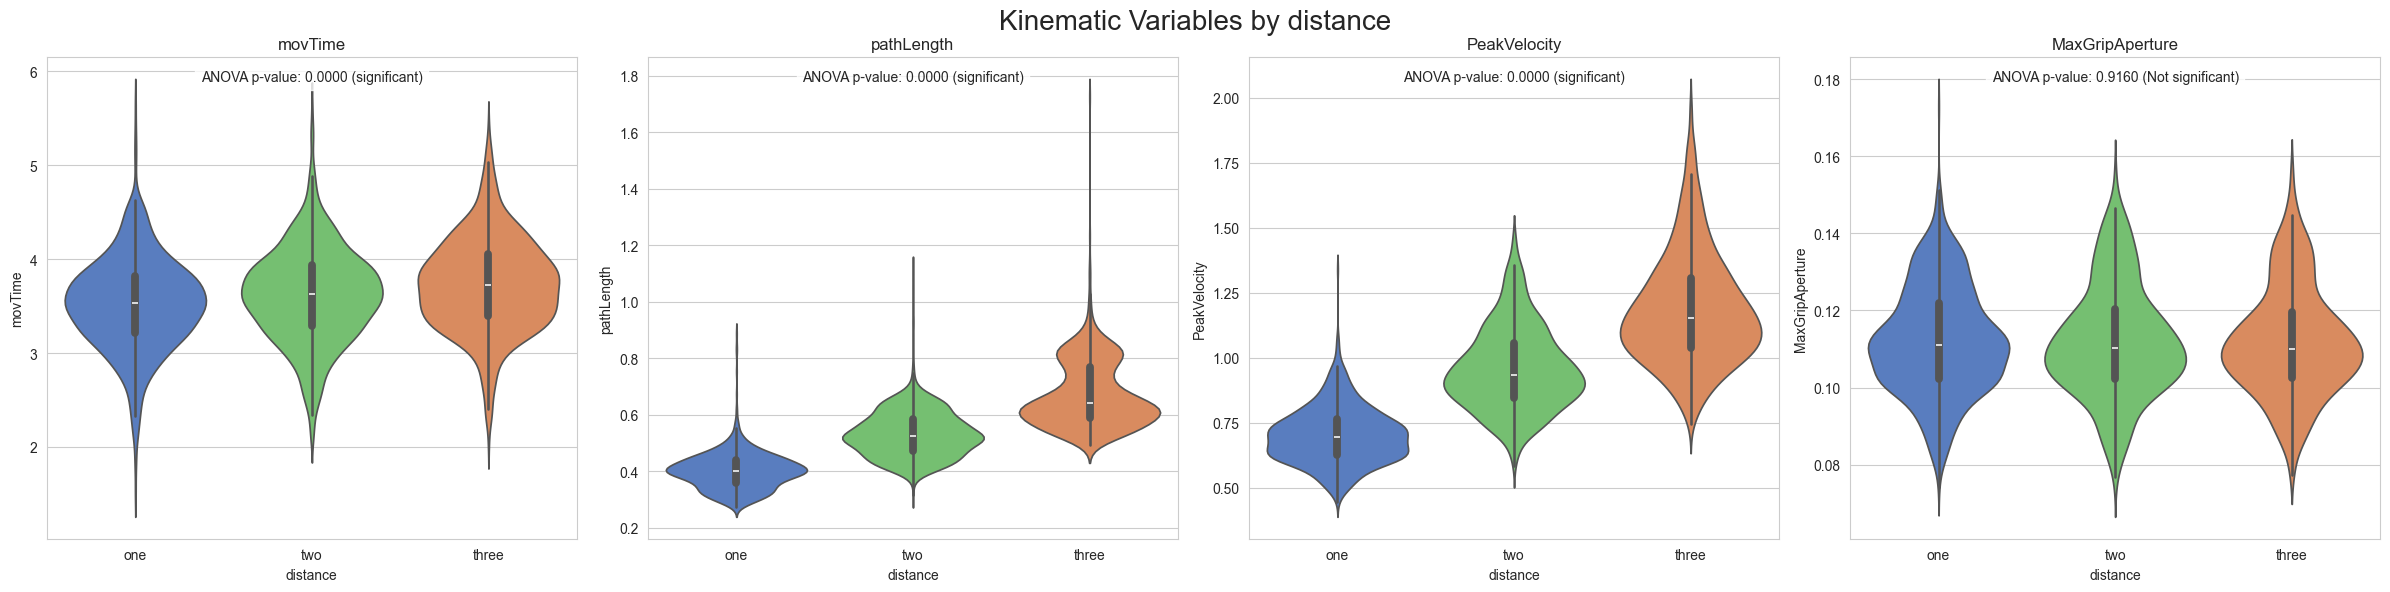


--- Analysing by: visCond ---


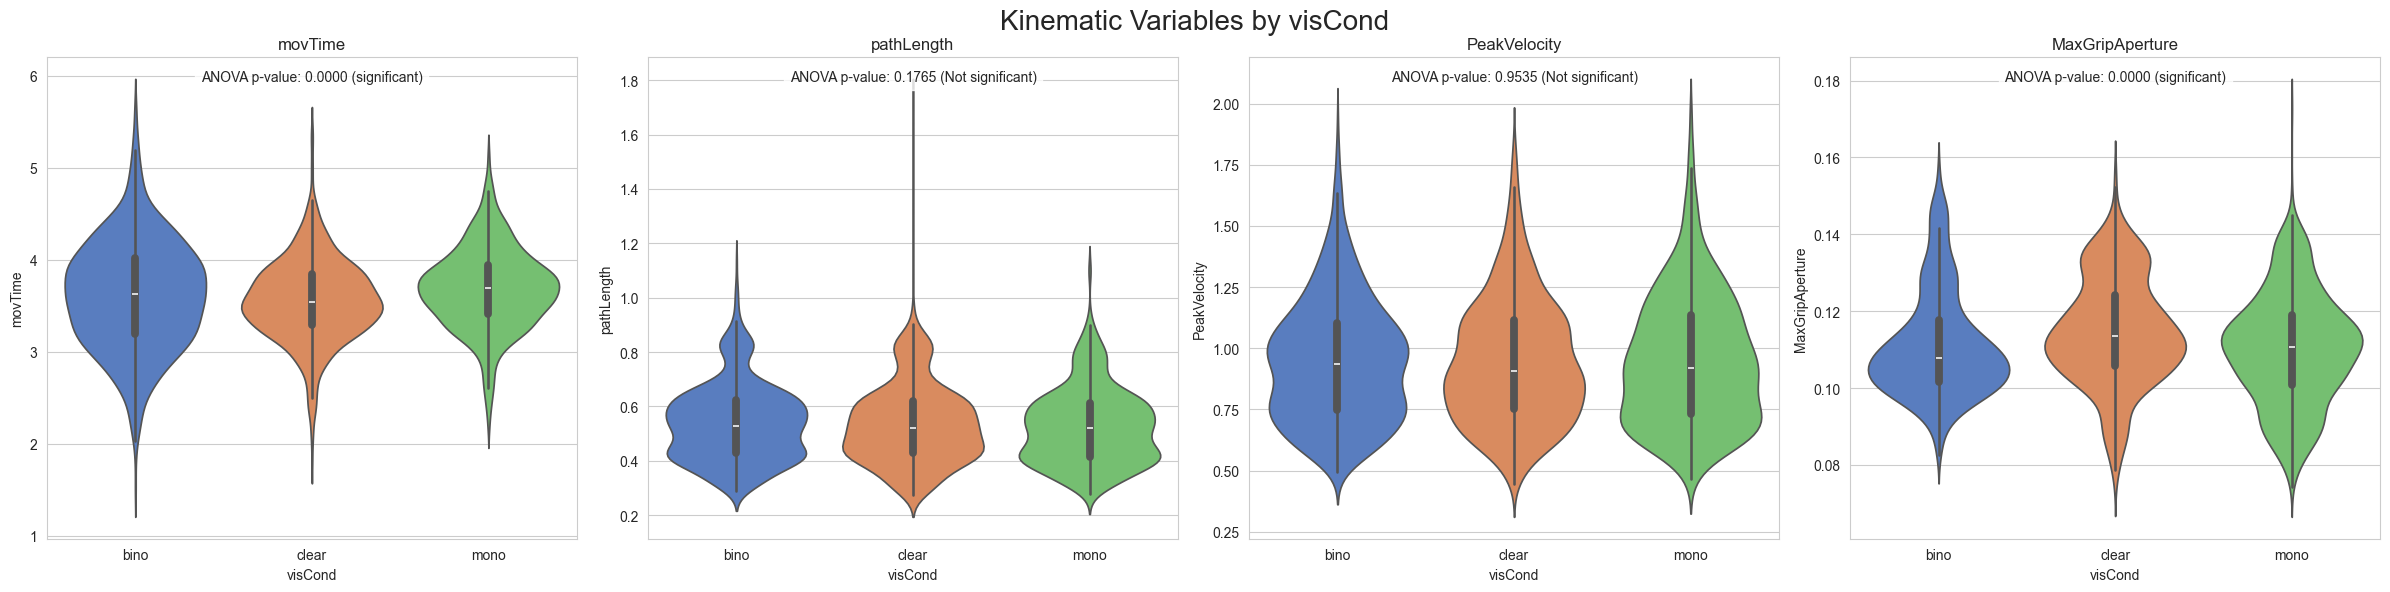


--- Analysing by: surface ---


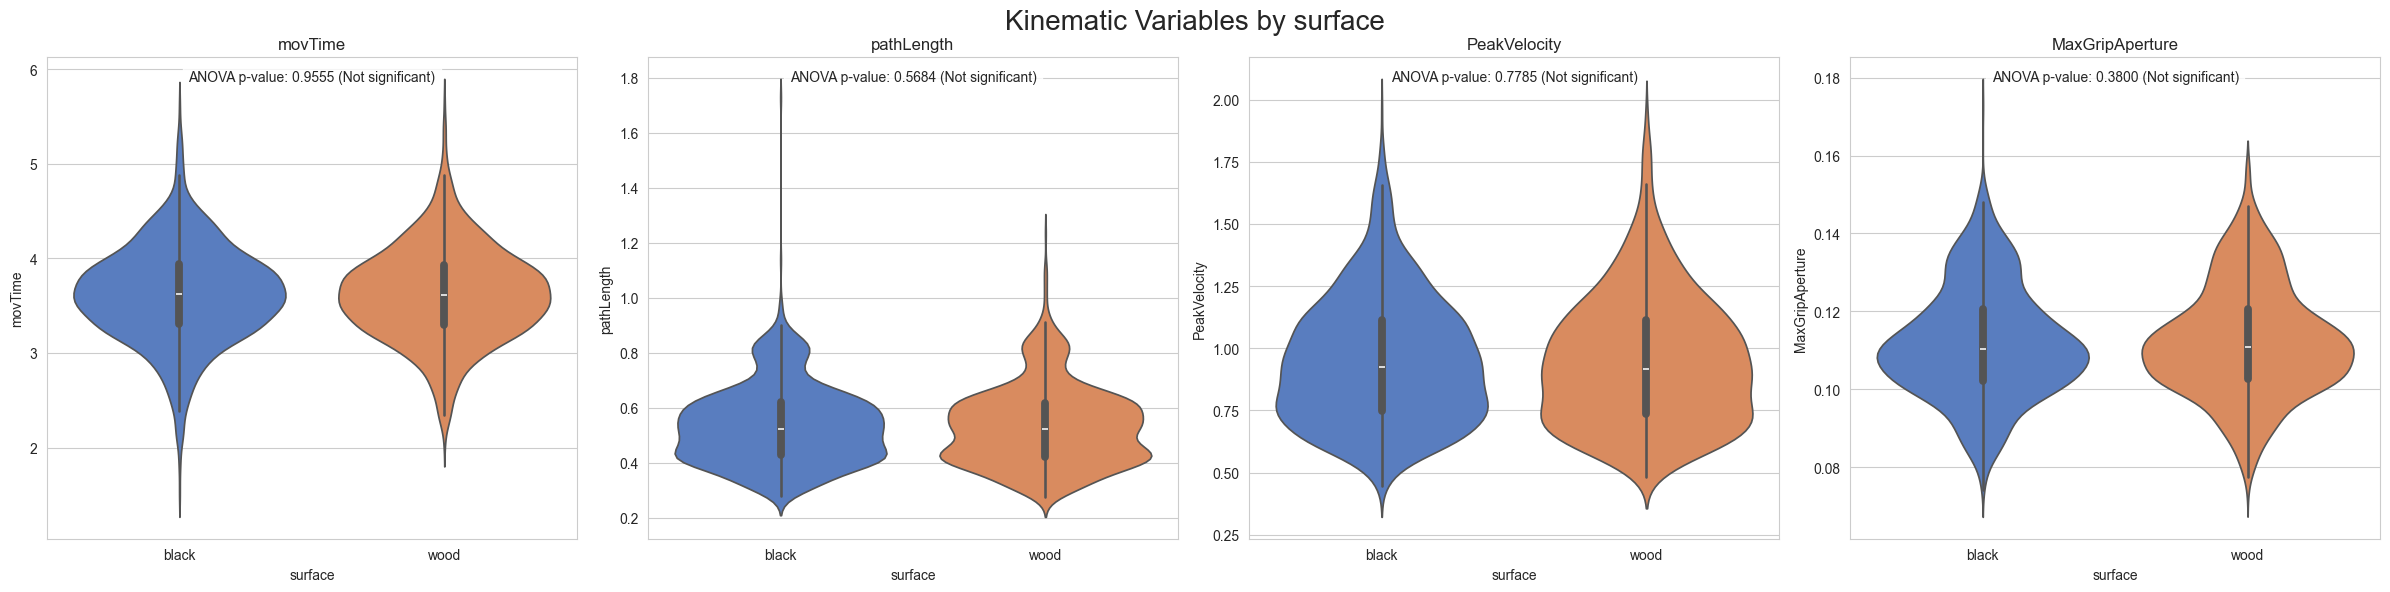

In [15]:
# 4.2 Impact of Experimental Conditions on Kinematics
print("--- Impact of Experimental Conditions on Key Kinematics (with ANOVA) ---")
conditions = ["distance", "visCond", "surface"]
plot_vars = ['movTime', 'pathLength', 'PeakVelocity', 'MaxGripAperture']

for cond in conditions:
    print(f"\n--- Analysing by: {cond} ---")
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(f"Kinematic Variables by {cond}", fontsize=20, y=0.98)  # Moved title down
    axes = axes.flatten()

    for i, var in enumerate(plot_vars):
        if var in df.columns:
            order = ["one", "two", "three"] if cond == "distance" else sorted(df[cond].dropna().unique())

            sns.violinplot(
                ax=axes[i],
                x=cond,
                y=var,
                data=df,
                hue=cond,  # Explicitly set hue to avoid FutureWarning
                palette="muted",
                order=order,
                legend=False
            )
            axes[i].set_title(f"{var}")

            # Perform and display ANOVA p value
            try:
                if hasattr(df[cond], 'cat'):
                    categories = df[cond].cat.categories
                else:
                    categories = sorted(df[cond].dropna().unique())

                groups = [df[var][df[cond] == c].dropna() for c in categories]
                if len(groups) > 1:
                    f_val, p_val = stats.f_oneway(*groups)
                    is_significant = " (significant)" if p_val < 0.05 else " (Not significant)"
                    axes[i].text(
                        0.5, 0.95,  # Moved text down to avoid overlap
                        f"ANOVA p-value: {p_val:.4f}{is_significant}",
                        transform=axes[i].transAxes,
                        fontsize=10,
                        ha="center",
                        bbox=dict(facecolor="white", alpha=0.8)
                    )
            except Exception as e:
                print(f"ANOVA failed for {var} by {cond}: {e}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Add space at the top for the main title
    plt.show()

# 1. Print a message indicating analysis of experimental condition effects on kinematics using ANOVA.
# 2. Define:
#    a. A list of experimental conditions (e.g., distance, visual condition, surface).
#    b. A list of key kinematic variables to analyze.
#
# 3. For each condition in the list:
#    a. Print the current condition being analyzed.
#    b. Create a row of 4 subplots for visualizing kinematic variables.
#    c. Set a title for the entire row of plots.
#
#    d. For each kinematic variable:
#       i. Check if it exists in the dataset.
#       ii. Define the plotting order based on the condition (custom for distance, sorted otherwise).
#       iii. Plot a violin plot showing the distribution of the variable across levels of the condition.
#       iv. Set the subplot title to the variable name.
#
#       v. Perform ANOVA:
#          - Group the data by condition.
#          - Run one-way ANOVA (F-test) across the groups.
#          - Display the ANOVA p-value on the plot.
#          - Indicate whether the result is statistically significant (p < 0.05).
#
#       vi. Handle and report any errors during ANOVA.
#
# 4. Adjust layout to fit titles and plots neatly.
# 5. Display all the plots for the current condition.


* **movTime, pathLength, PeakVelocity:** For all 3 variables, the violins shift updard as the distance increases from 'one' to 'three'. The shape of the violin also widens, which shows more variability in the movements to farther targets. The ANOVA p-value of 0 (Significant) provides proof that target distance has a major impact on these core kinematic parameters.
* **MaxGripAperture:** The 3 violins are almost perfectly aligned, showing that the distribution of maximum grip aperture is nearly identical across all three distances. The ANOVA p-value of 0.9160 (not significant) confirms this.
* **Crucial Insight:** We know in classical graping studies, grip aperture increases with target distance. But the data suggests that for this aiming task, this is not the case. Subjects pre shaped their hands to the same aperture regardless of distance. This might suggest that grip strategy might be independent of the transport component (the reach itself) in this specific task

## Dimensionality Reduction with PCA

Performing Principal Component Analysis ---
Selected 194 features for PCA
PCA fitting complete


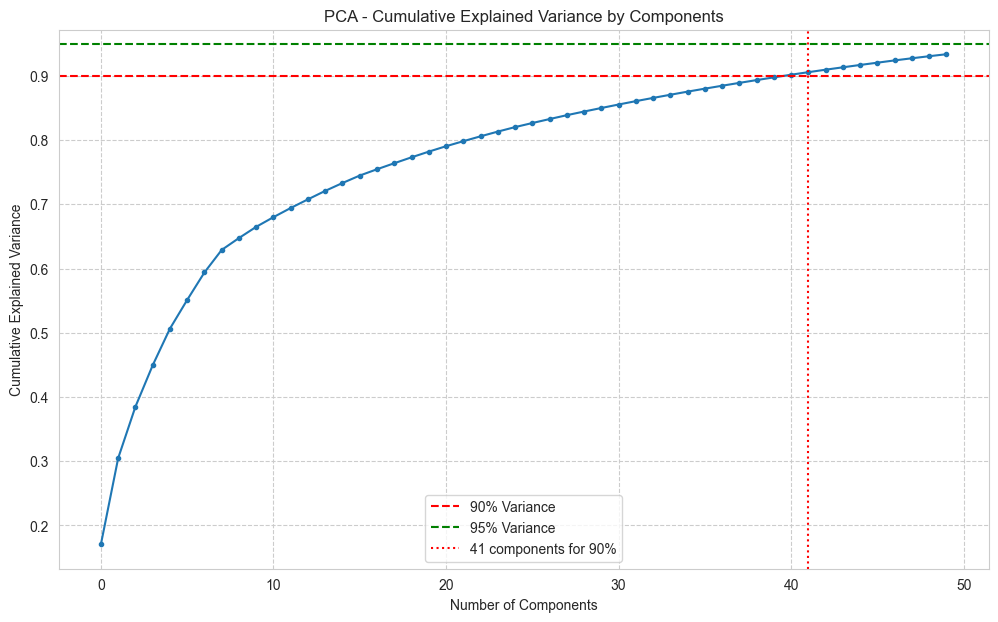

Variance explained by first 2 components: 0.305
Variance explained by first 5 components: 0.506
Number of components to explain 90% of variance: 41


In [16]:
print("Performing Principal Component Analysis ---")

#1. Select only numerical kinematic features for PCA
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Exclude identifiers, raw visual acuity data, subject demographics, and other non kinematic variables
cols_to_exclude = ['subjName', 'trialN', 'clear.logMAR', 'mono.logMAR', 'bino.logMAR', 'clear.logCS', 'mono.logCS', 'bino.logCS', 'clear.disparity', 'mono.disparity', 'bino.disparity', 'Age', 'distance_ordinal']

features_for_pca = [col for col in numerical_cols if col not in cols_to_exclude]
print(f"Selected {len(features_for_pca)} features for PCA")

# 2. Scale the data before applying PCA
scalar = StandardScaler()
scaled_features = scalar.fit_transform(df[features_for_pca])

# 3. Perform PCA
pca = PCA(n_components=50)
principal_components = pca.fit_transform(scaled_features)
print("PCA fitting complete")

# 4. Analyse the Explained variance
plt.figure(figsize=[12, 7])
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.', linestyle="-")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance by Components")

# Add reference lines
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Variance")
num_comp_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.90)[0][0] + 1
plt.axvline(x=num_comp_90, color="r", linestyle=":", label=f"{num_comp_90} components for 90%")

plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

print(f"Variance explained by first 2 components: {np.sum(pca.explained_variance_ratio_[:2]):.3f}")
print(f"Variance explained by first 5 components: {np.sum(pca.explained_variance_ratio_[:5]):.3f}")
print(f"Number of components to explain 90% of variance: {num_comp_90}")


# 1. Print message indicating the start of PCA.
#
# 2. Select relevant features for PCA:
#    a. Identify all numerical columns in the dataset.
#    b. Define a list of columns to exclude (identifiers, demographics, non-kinematic data).
#    c. Filter out excluded columns to get the final feature list for PCA.
#    d. Print how many features were selected.
#
# 3. Standardize (scale) the selected features using standard scaling (mean = 0, std = 1).
#
# 4. Perform Principal Component Analysis (PCA):
#    a. Initialize PCA with up to 50 components.
#    b. Fit PCA to the scaled features and transform the data.
#    c. Print confirmation of PCA completion.
#
# 5. Plot cumulative explained variance:
#    a. Create a line plot showing how much variance is explained as more components are added.
#    b. Add horizontal lines at 90% and 95% variance.
#    c. Add a vertical line at the number of components needed to reach 90% variance.
#    d. Display the plot with labels, grid, and legend.
#
# 6. Print:
#    a. Total variance explained by the first 2 components.
#    b. Total variance explained by the first 5 components.
#    c. Number of components needed to explain 90% of the variance.


The plot shows that the first few principal components capture a large amount of information. The curve rises steeply at first and then begins to flatten out.

* **Variance explained by first 2 components: 0.305** This means that if we reduce all ~200 kinamatic features down to just two new features (PC1 and PC2), we will still retain 30.5% of the total variance from the original dataset.
* **Variance explained by first 5 components: 0.506:** With just 5 components, we capture over half of all the information.
* **Number of components to explain 90% of variance: 41:** It tells us that we can reduce our dataset from over 200 features to just 41 and still be confident we are working with 90% of the original information. We can use this to make the model faster, less prone to overfitting, and more robust

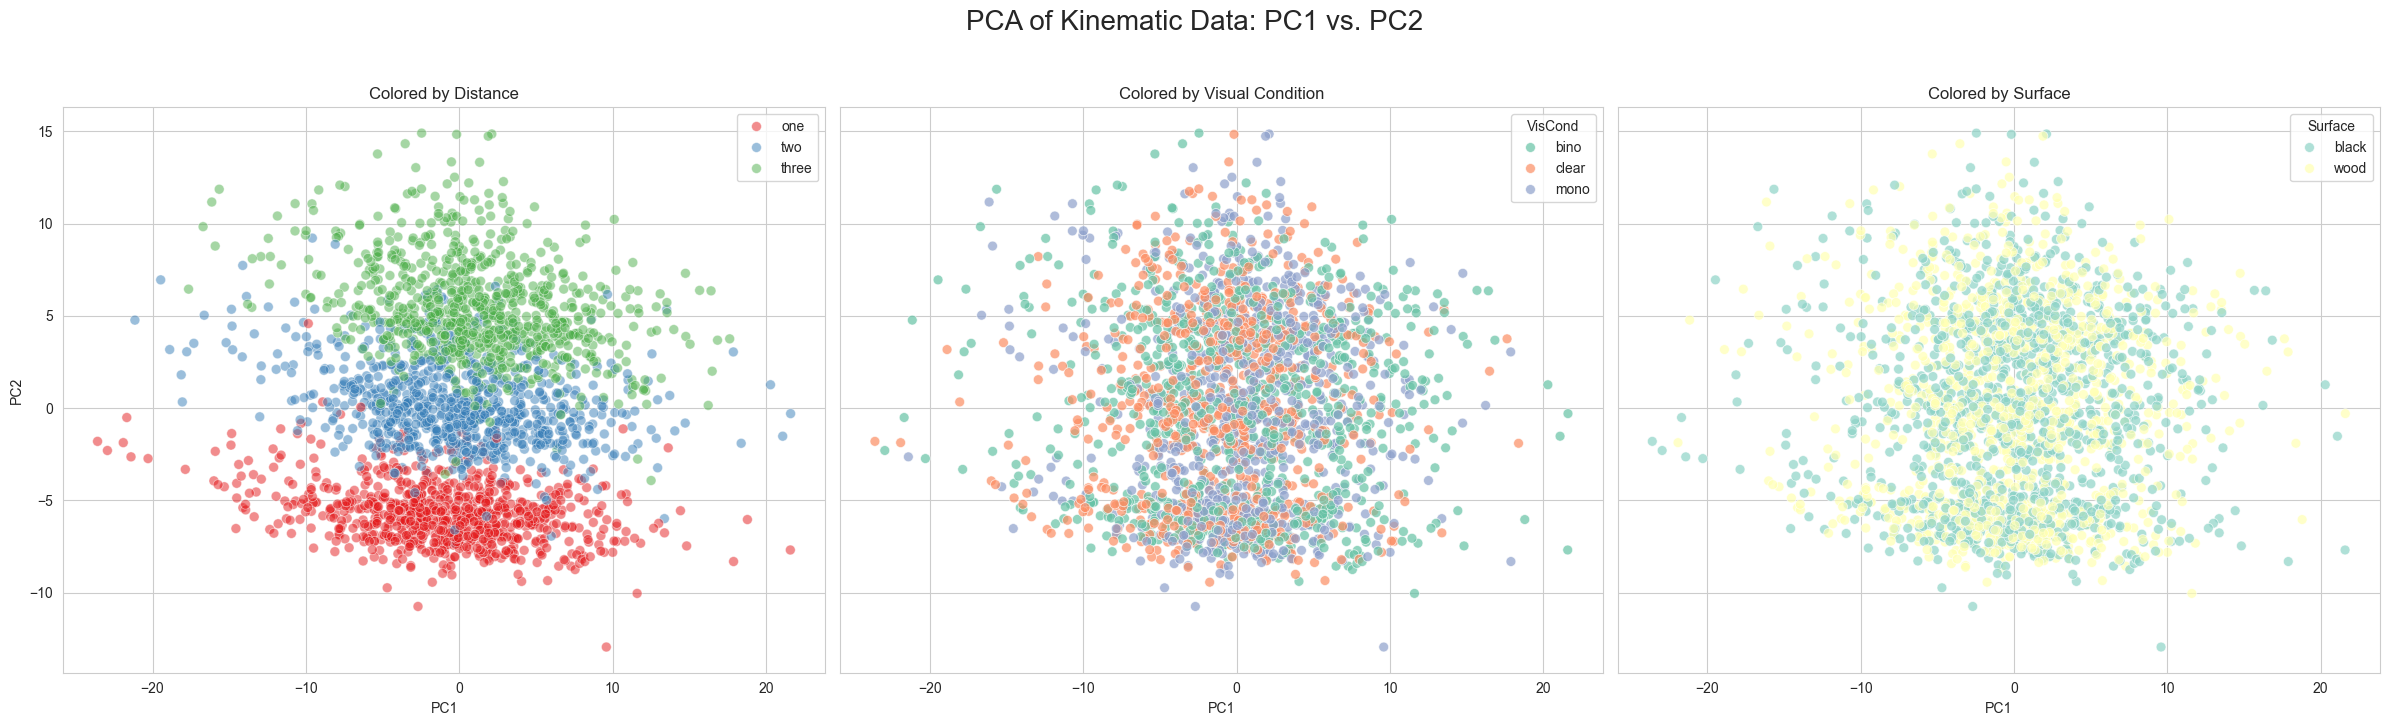

In [17]:
# 5. Visualise the first 2 principal components
pca_df = pd.DataFrame(data=principal_components[:, :2], columns=["PC1", "PC2"])
viz_df = pd.concat([pca_df, df[["distance", "visCond", "surface"]]], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharex=True, sharey=True)
fig.suptitle("PCA of Kinematic Data: PC1 vs. PC2", fontsize=20, y=1.03)

# Plot colored by Distance
sns.scatterplot(ax=axes[0], x="PC1", y="PC2", data=viz_df, hue="distance", hue_order=["one", "two", "three"], palette="Set1", alpha=0.5, s=50)
axes[0].set_title("Colored by Distance")
axes[0].legend()

# Plot colored by Visual Condition
sns.scatterplot(ax=axes[1], x="PC1", y="PC2", data=viz_df, hue="visCond", palette="Set2", alpha=0.7, s=50)
axes[1].set_title("Colored by Visual Condition")
axes[1].legend(title="VisCond")

# Plot colored by Surface
sns.scatterplot(ax=axes[2], x="PC1", y="PC2", data=viz_df, hue="surface", palette="Set3", alpha=0.7, s=50)
axes[2].set_title("Colored by Surface")
axes[2].legend(title="Surface")

plt.tight_layout()
plt.show()


# 1. Create a new DataFrame with the first two principal components (PC1 and PC2).
# 2. Combine this PCA data with categorical variables: 'distance', 'visCond', and 'surface'.
#
# 3. Create a figure with 3 side-by-side scatter plots, sharing the same axes.
# 4. Set a common title for the figure: "PCA of Kinematic Data: PC1 vs. PC2".
#
# 5. For each subplot:
#    a. Plot a scatter plot of PC1 vs. PC2.
#    b. Color the points by one of the categorical variables:
#       - First plot: color by 'distance'.
#       - Second plot: color by 'visCond'.
#       - Third plot: color by 'surface'.
#    c. Set appropriate titles and legends for each subplot.
#
# 6. Adjust the layout to prevent overlap.
# 7. Display the plots.


# Starting EDA of Prehension Dataset

## On this dataset we will focus on grasping an object, we pay special attention to grip related variables like MGA

In [18]:
try:
    df_pre_corr = pd.read_csv("C:/CourseWork/Dissertation Classifying grip strategies using machine learning/data/02_processed/prehension_master_dataset.csv")
    print("Successfully loaded prehension master dataset from CSV")
except FileNotFoundError:
    print("FATAL ERROR: Corrected prehension dataset not found")
    exit()

print("\n--- Initial Data Inspection ---")
print(f"Dataset Shape: {df_pre_corr.shape}")

# TRY to load the prehension master dataset from the specified CSV file
#     IF successful
#         PRINT success message
#     ELSE IF file is not found
#         PRINT fatal error message
#         EXIT the program
#
# PRINT section header for data inspection
# PRINT the shape (rows, columns) of the loaded dataset


Successfully loaded prehension master dataset from CSV

--- Initial Data Inspection ---
Dataset Shape: (2826, 184)


# Step 2: Data Cleaning and Preprocessing


In [19]:
# 1. Identify and remove the old, faulty summary columns (ending in _y)
cols_to_drop = [col for col in df_pre_corr.columns if col.endswith('_y')]
df_pre_corr.drop(columns=cols_to_drop, inplace=True)
print(f"Removed {len(cols_to_drop)} old summary columns (ending in '_y').")

# DEFINE a list of columns to drop: all columns in the dataset whose names end with '_y'
# REMOVE those columns from the dataset
# PRINT how many columns were removed

Removed 15 old summary columns (ending in '_y').


In [20]:
# 2. Rename the new, correct summary columns by removing the _x suffix
rename_dict = {col: col[:-2] for col in df_pre_corr.columns if col.endswith('_x')}
df_pre_corr.rename(columns=rename_dict, inplace=True)
print(f"Renamed {len(rename_dict)} new summary columns to be the primary variables.")

# CREATE a dictionary to rename columns: for each column ending with '_x', map it to the same name without the '_x' suffix
# RENAME the columns in the dataset using this dictionary
# PRINT how many columns were renamed

Renamed 15 new summary columns to be the primary variables.


In [21]:
categorical_cols = ['subjName', 'visCond', 'surface', 'distance']
for col in categorical_cols:
    df_pre_corr[col] = df_pre_corr[col].astype('category')
print("Converted categorical columns to 'category' dtype")

# DEFINE a list of categorical columns
# FOR each column in the list:
#     CONVERT the column's data type to 'category' in the dataset
# PRINT confirmation that categorical columns were converted

Converted categorical columns to 'category' dtype


In [22]:
distance_mapping = {"near": 1, "middle": 2, "far": 3}
df_pre_corr["distance_ordinal"] = df_pre_corr["distance"].cat.rename_categories(distance_mapping).astype(int)
print("Created 'distance_ordinal' column")

print("\n --- Preprocessing Complete. The Dataset is now clean and verified ---")
df_pre_corr.info(verbose=False, max_cols=10)

# DEFINE a mapping of distance categories to ordinal values (near → 1, middle → 2, far → 3)
# CREATE a new column 'distance_ordinal' by applying the mapping to the 'distance' categorical column and converting it to integer
# PRINT confirmation that the new column was created
#
# PRINT message indicating preprocessing is complete
# DISPLAY a summary of the dataset structure (non-verbose, showing up to 10 columns)

Created 'distance_ordinal' column

 --- Preprocessing Complete. The Dataset is now clean and verified ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Columns: 170 entries, subjName to distance_ordinal
dtypes: category(4), float64(157), int64(9)
memory usage: 3.6 MB


# Step 2: Univariate Analysis

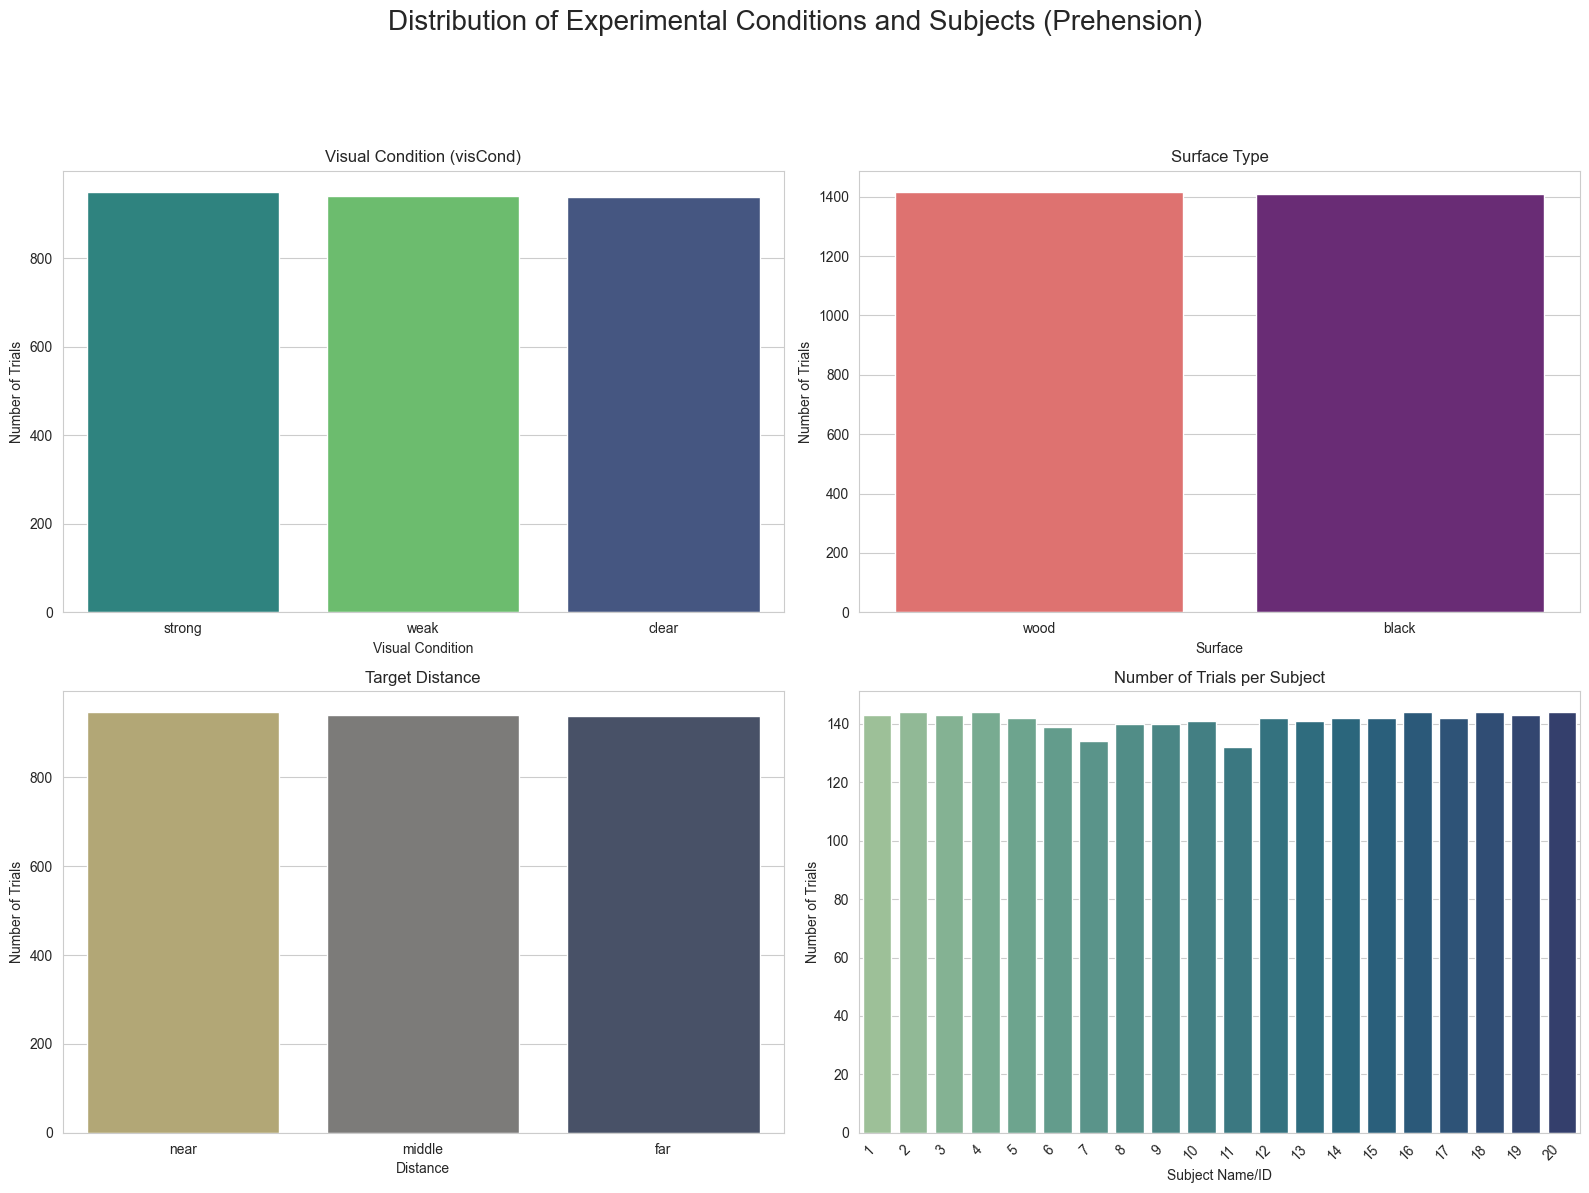

In [23]:
# --- Univariate Analysis: Categorical & Subject Variables ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Experimental Conditions and Subjects (Prehension)', fontsize=20, y=1.02)

sns.countplot(ax=axes[0, 0], x='visCond', hue='visCond', data=df_pre_corr, palette='viridis',
              order=df_pre_corr['visCond'].value_counts().index, legend=False)
axes[0, 0].set_title('Visual Condition (visCond)')
axes[0, 0].set_xlabel('Visual Condition')
axes[0, 0].set_ylabel('Number of Trials')

sns.countplot(ax=axes[0, 1], x='surface', hue='surface', data=df_pre_corr, palette='magma',
              order=df_pre_corr['surface'].value_counts().index, legend=False)
axes[0, 1].set_title('Surface Type')
axes[0, 1].set_xlabel('Surface')
axes[0, 1].set_ylabel('Number of Trials')

sns.countplot(ax=axes[1, 0], x='distance', hue='distance', data=df_pre_corr, palette='cividis',
              order=['near', 'middle', 'far'], legend=False)
axes[1, 0].set_title('Target Distance')
axes[1, 0].set_xlabel('Distance')
axes[1, 0].set_ylabel('Number of Trials')


# --- Plot 4: Trials per Subject ---
sns.countplot(ax=axes[1, 1], x='subjName', hue='subjName', data=df_pre_corr, palette='crest', legend=False)
axes[1, 1].set_title('Number of Trials per Subject')
axes[1, 1].set_xlabel('Subject Name/ID')
axes[1, 1].set_ylabel('Number of Trials')

plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha="right")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# CREATE a 2x2 grid of subplots with a specified figure size
# SET a main title for the entire figure
#
# PLOT count of trials for each visual condition on subplot (0, 0)
#     - Use 'visCond' for x-axis and hue
#     - Set color palette and order by frequency
#     - Add title and axis labels
#
# PLOT count of trials for each surface type on subplot (0, 1)
#     - Use 'surface' for x-axis and hue
#     - Set color palette and order by frequency
#     - Add title and axis labels
#
# PLOT count of trials for each target distance on subplot (1, 0)
#     - Use 'distance' for x-axis and hue
#     - Set color palette and fixed order: near, middle, far
#     - Add title and axis labels
#
# PLOT count of trials per subject on subplot (1, 1)
#     - Use 'subjName' for x-axis and hue
#     - Set color palette
#     - Add title and axis labels
#     - Rotate x-axis labels for better readability
#
# ADJUST layout to prevent overlap and fit the main title
# DISPLAY the final figure


This plot confirms the experimental design. We have well balanced design across all conditions. The bottom right plot shows that all 20 subjects contributed nearly identical number of trials

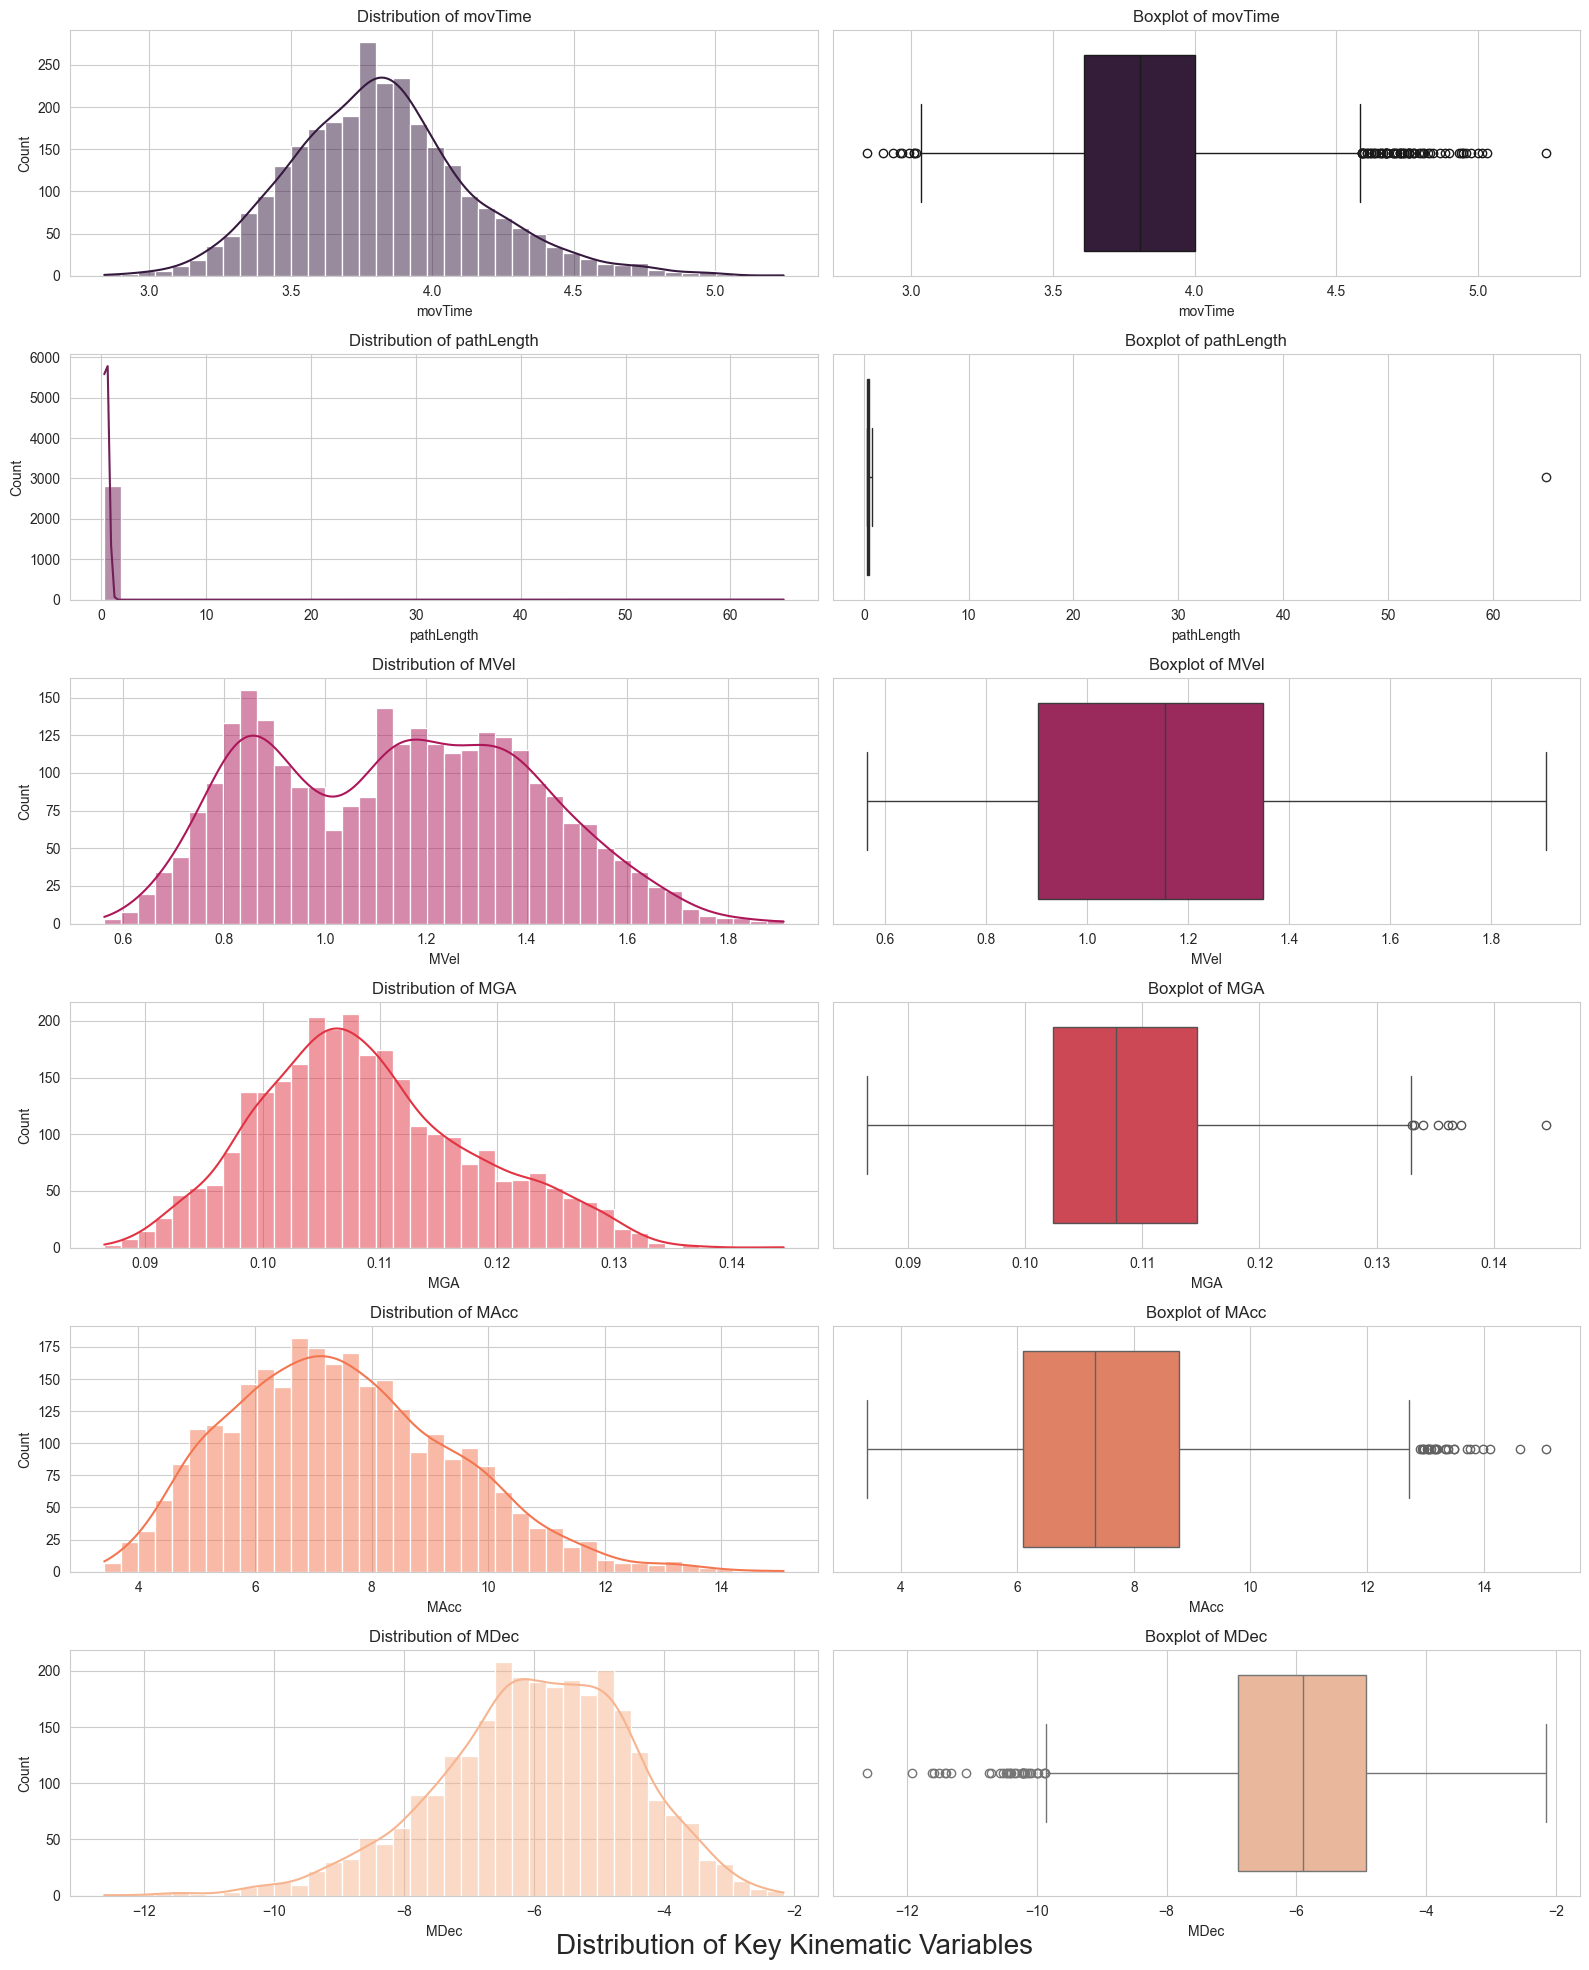

In [24]:
# Distribution of key kinematic variables
key_kinematic_vars_corr = ['movTime', 'pathLength', 'MVel', 'MGA', 'MAcc', 'MDec'
]
fig, axes = plt.subplots(len(key_kinematic_vars_corr), 2, figsize=(16, 20))
fig.suptitle('Distribution of Key Kinematic Variables', fontsize=20, y=0.01)

for i, var in enumerate(key_kinematic_vars_corr):
    sns.histplot(ax=axes[i, 0], data=df_pre_corr, x=var, kde=True, bins=40, color=sns.color_palette("rocket", len(key_kinematic_vars_corr))[i])
    axes[i, 0].set_title(f"Distribution of {var}")
    sns.boxplot(ax=axes[i, 1], data=df_pre_corr, x=var, color=sns.color_palette("rocket", len(key_kinematic_vars_corr))[i])
    axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()

# DEFINE a list of key kinematic variables
#
# CREATE a figure with multiple rows and 2 columns of subplots (one row per variable)
# SET a main title for the figure
#
# FOR each variable in the list:
#     PLOT a histogram with KDE on the left subplot of the row
#         - Use 40 bins and assign a unique color
#         - Set the title to show the variable name
#     PLOT a boxplot on the right subplot of the row
#         - Use the same color
#         - Set the title accordingly
#
# ADJUST layout to avoid overlap
# DISPLAY the complete figure

This plot revealed the outlier issue. The pathLength histogram is squished to the left and its boxplot is compressed into a thin line.

# Remove Outlier

Found 1 trials with a physically impossible pathLength ( > 2.0m).

Details of the outlier trials:
    subjName  trialN  pathLength
863        7      10   65.081096

Original dataset size: 2826
New dataset size after removing outliers: 2825


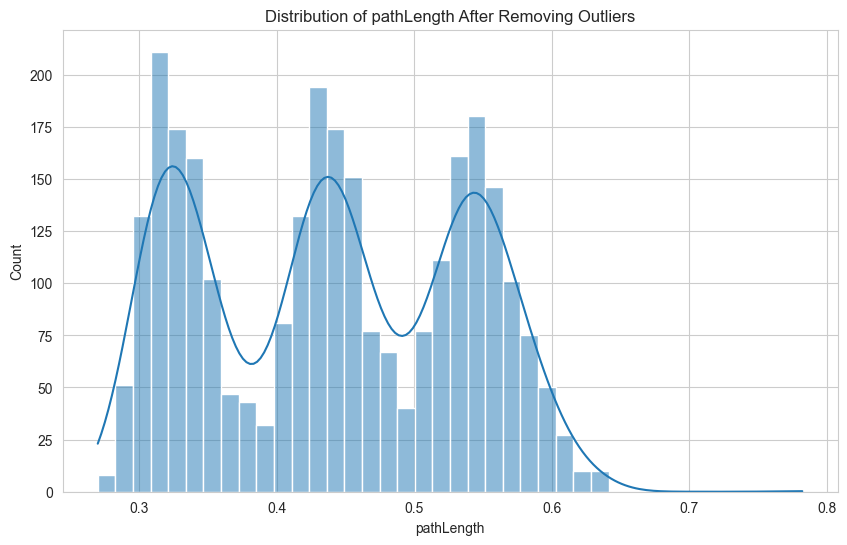

In [25]:
# Set the threshold to 2 to remove the outlier
outlier_threshold = 2.0
outliers = df_pre_corr[df_pre_corr['pathLength'] > outlier_threshold]

print(f"Found {len(outliers)} trials with a physically impossible pathLength ( > {outlier_threshold}m).")
print("\nDetails of the outlier trials:")
print(outliers[['subjName', 'trialN', 'pathLength']])

df_pre_final = df_pre_corr[df_pre_corr['pathLength'] <= outlier_threshold].copy()

print(f"\nOriginal dataset size: {len(df_pre_corr)}")
print(f"New dataset size after removing outliers: {len(df_pre_final)}")

plt.figure(figsize=(10,6))
sns.histplot(df_pre_final['pathLength'], bins=40, kde=True)
plt.title("Distribution of pathLength After Removing Outliers")
plt.show()

# SET an outlier threshold for 'pathLength' (e.g., 2.0 meters)
#
# IDENTIFY rows where 'pathLength' exceeds the threshold
# PRINT the number of outlier trials found
# PRINT the subject name, trial number, and path length for these outliers
#
# CREATE a new dataset by removing the outlier rows
# COPY the filtered dataset to preserve data integrity
#
# PRINT the original and new dataset sizes
#
# PLOT a histogram (with KDE) of the 'pathLength' distribution in the cleaned dataset
# DISPLAY the plot


With the single outlier trial removed, the true structure of the pathLength data is revealed. It is a trimodal distribution, with 3 peaks.

The data is not one homogenous group but is composed of three subgroups. This suggests that the three different distance conditions (near, middle, far) produce three distinct distibutions of path length.

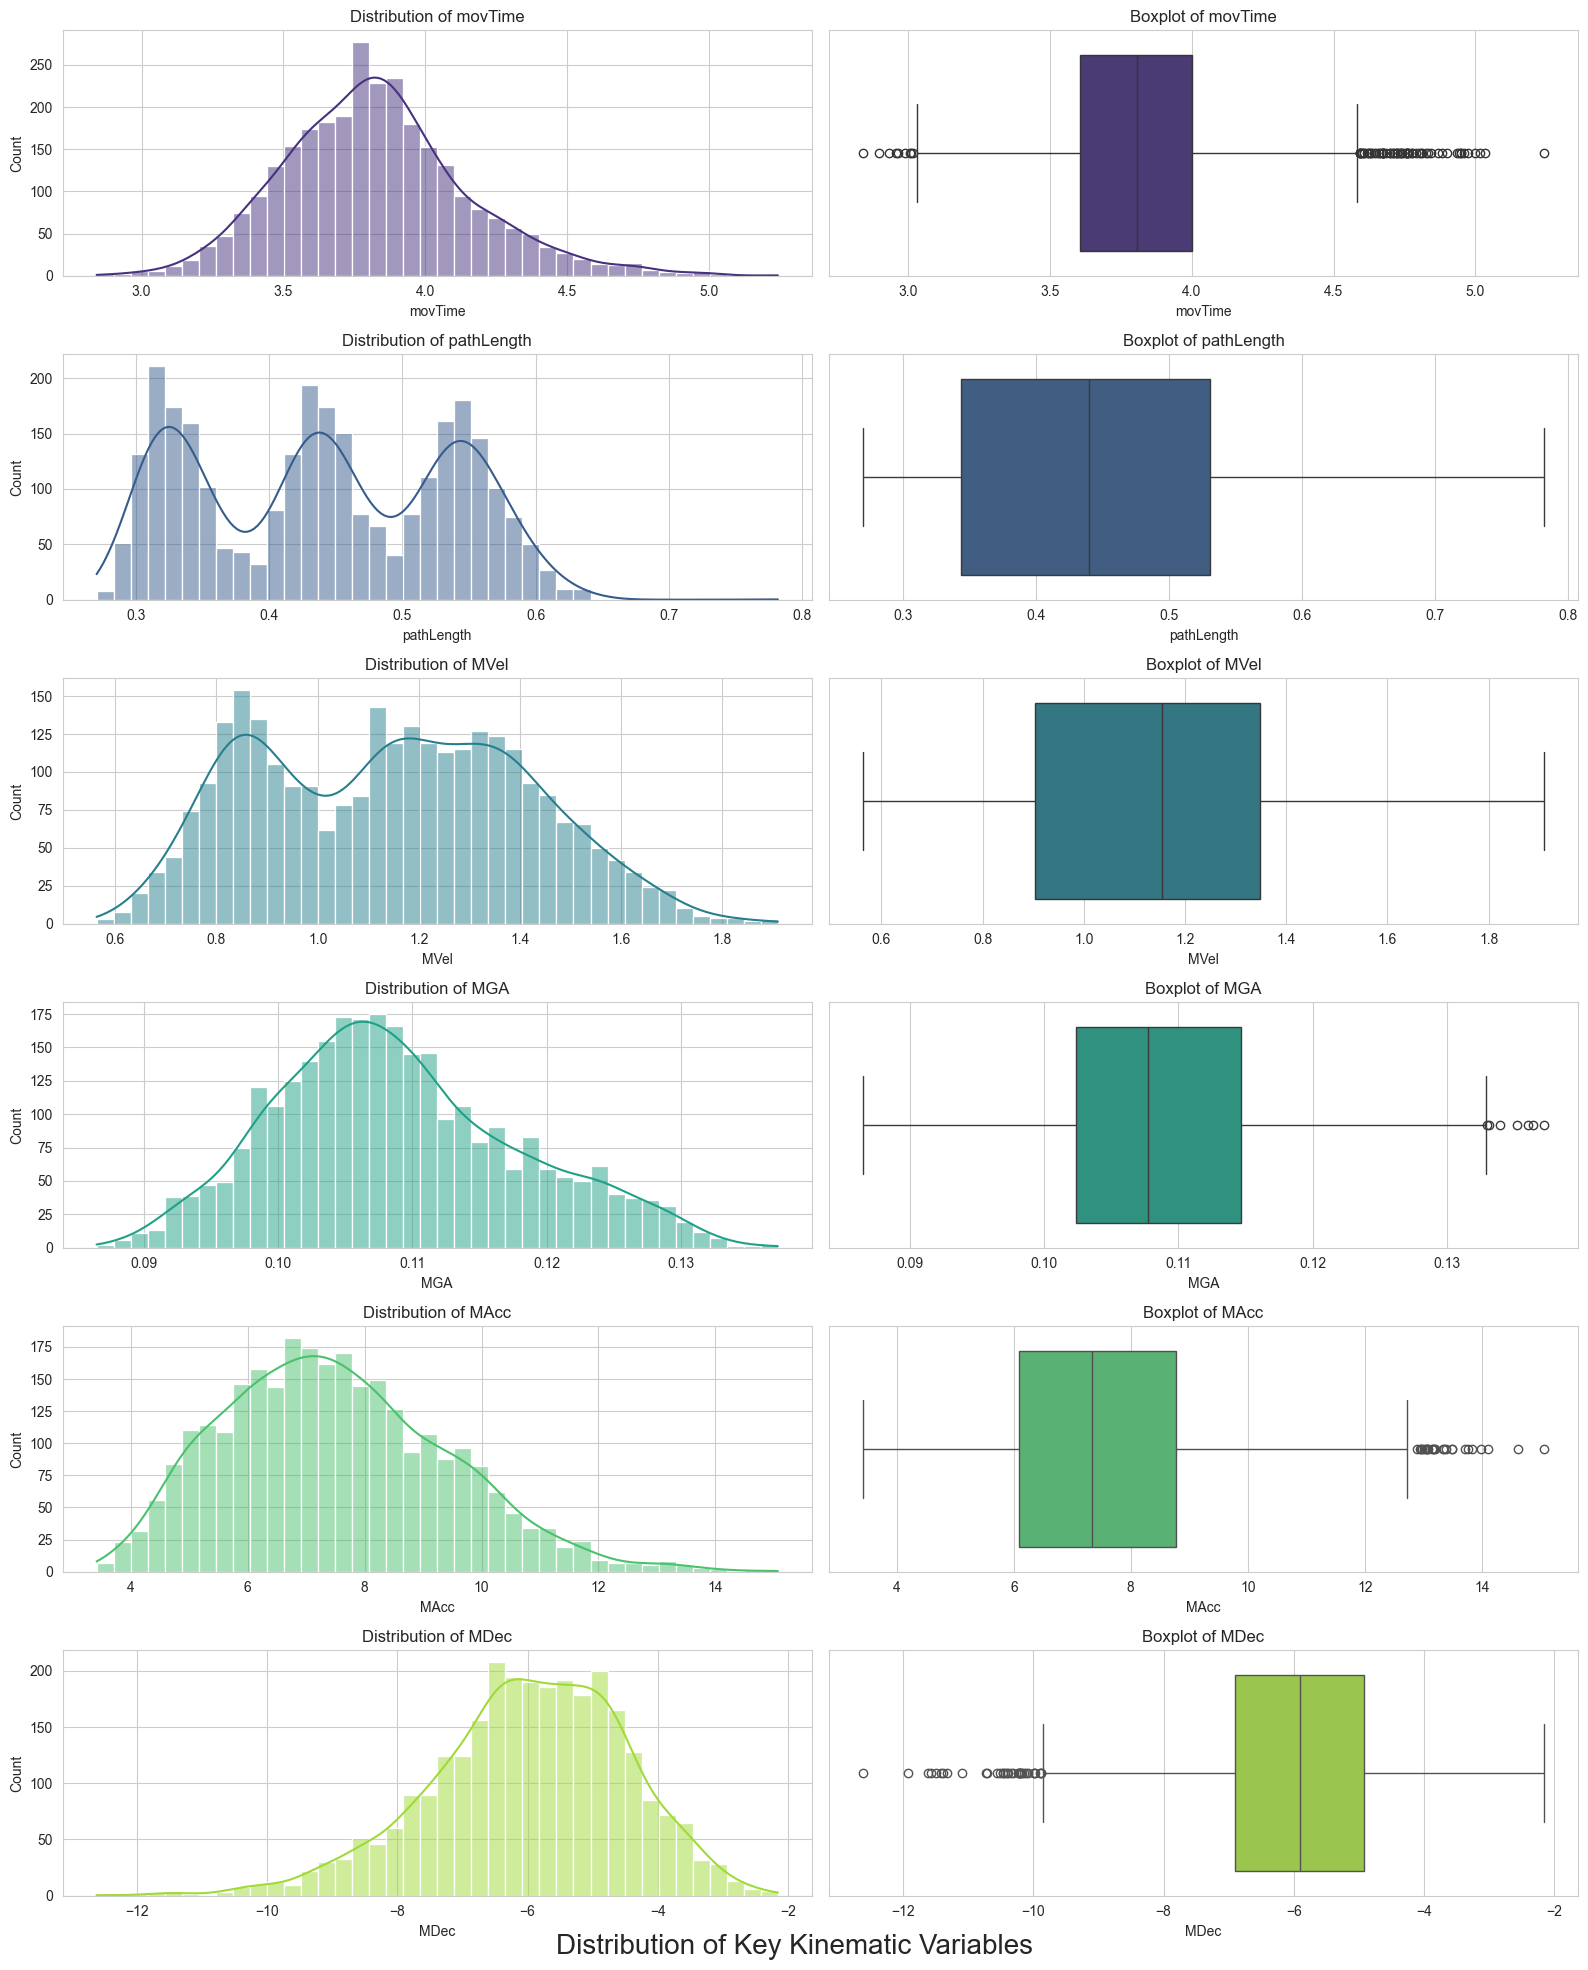

In [26]:
# Distribution of key kinematic variables
key_kinematic_vars_corr = ['movTime', 'pathLength', 'MVel', 'MGA', 'MAcc', 'MDec'
]
fig, axes = plt.subplots(len(key_kinematic_vars_corr), 2, figsize=(16, 20))
fig.suptitle('Distribution of Key Kinematic Variables', fontsize=20, y=0.01)

for i, var in enumerate(key_kinematic_vars_corr):
    sns.histplot(ax=axes[i, 0], data=df_pre_final, x=var, kde=True, bins=40, color=sns.color_palette("viridis", len(key_kinematic_vars_corr))[i])
    axes[i, 0].set_title(f"Distribution of {var}")
    sns.boxplot(ax=axes[i, 1], data=df_pre_final, x=var, color=sns.color_palette("viridis", len(key_kinematic_vars_corr))[i])
    axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()

# DEFINE a list of key kinematic variables
#
# CREATE a subplot grid with one row per variable and two columns (histogram and boxplot)
# SET a main title for the figure
#
# FOR each variable in the list:
#     PLOT a histogram with KDE on the left subplot using the cleaned dataset
#         - Use 40 bins and assign a unique color from the "viridis" palette
#         - Set the plot title
#     PLOT a boxplot on the right subplot using the same color
#         - Set the plot title
#
# ADJUST layout to prevent overlapping elements
# DISPLAY the figure


On this plot the major outlier is removed. Movement time displays a normal distribution around 4.0 s. Path length shows multiple peaks which means different movement strategies were used. Maximum velocity and acceleration shows right skewed distributions, while maximum grip aperture shows tight clustering around 0.11. Maximum deceleration follows a normal pattern centered at -8.

# Step 4: Bivariate and Multivariate Analysis

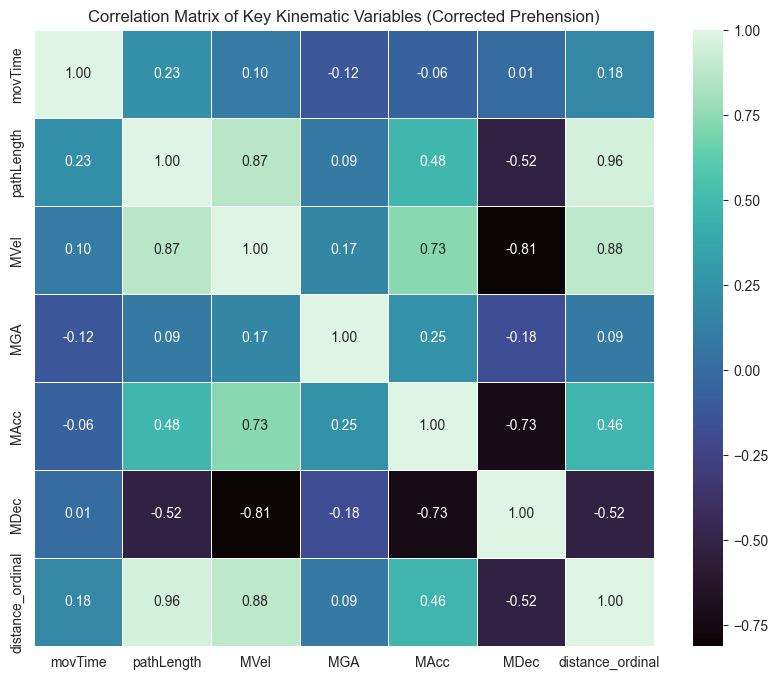

In [27]:
# --- Correlation Analysis (Corrected) ---
corr_vars = key_kinematic_vars_corr + ['distance_ordinal']
corr_matrix = df_pre_final[corr_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='mako', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Kinematic Variables (Corrected Prehension)')
plt.show()

# DEFINE the list of variables for correlation: key kinematic variables + 'distance_ordinal'
#
# COMPUTE the correlation matrix for these variables using the cleaned dataset
#
# CREATE a heatmap to visualize the correlation matrix
#     - Annotate the values
#     - Use the 'mako' color map
#     - Format values to 2 decimal places
#     - Add gridlines between cells
#
# SET the title of the heatmap
# DISPLAY the plot

This heatmap shows very strong positive correlations between distance and both pathLength (0.96) and MVel (0.88). It also shows strong negative correlations between MDec and both MVel (-0.81) and MAcc(-0.73).

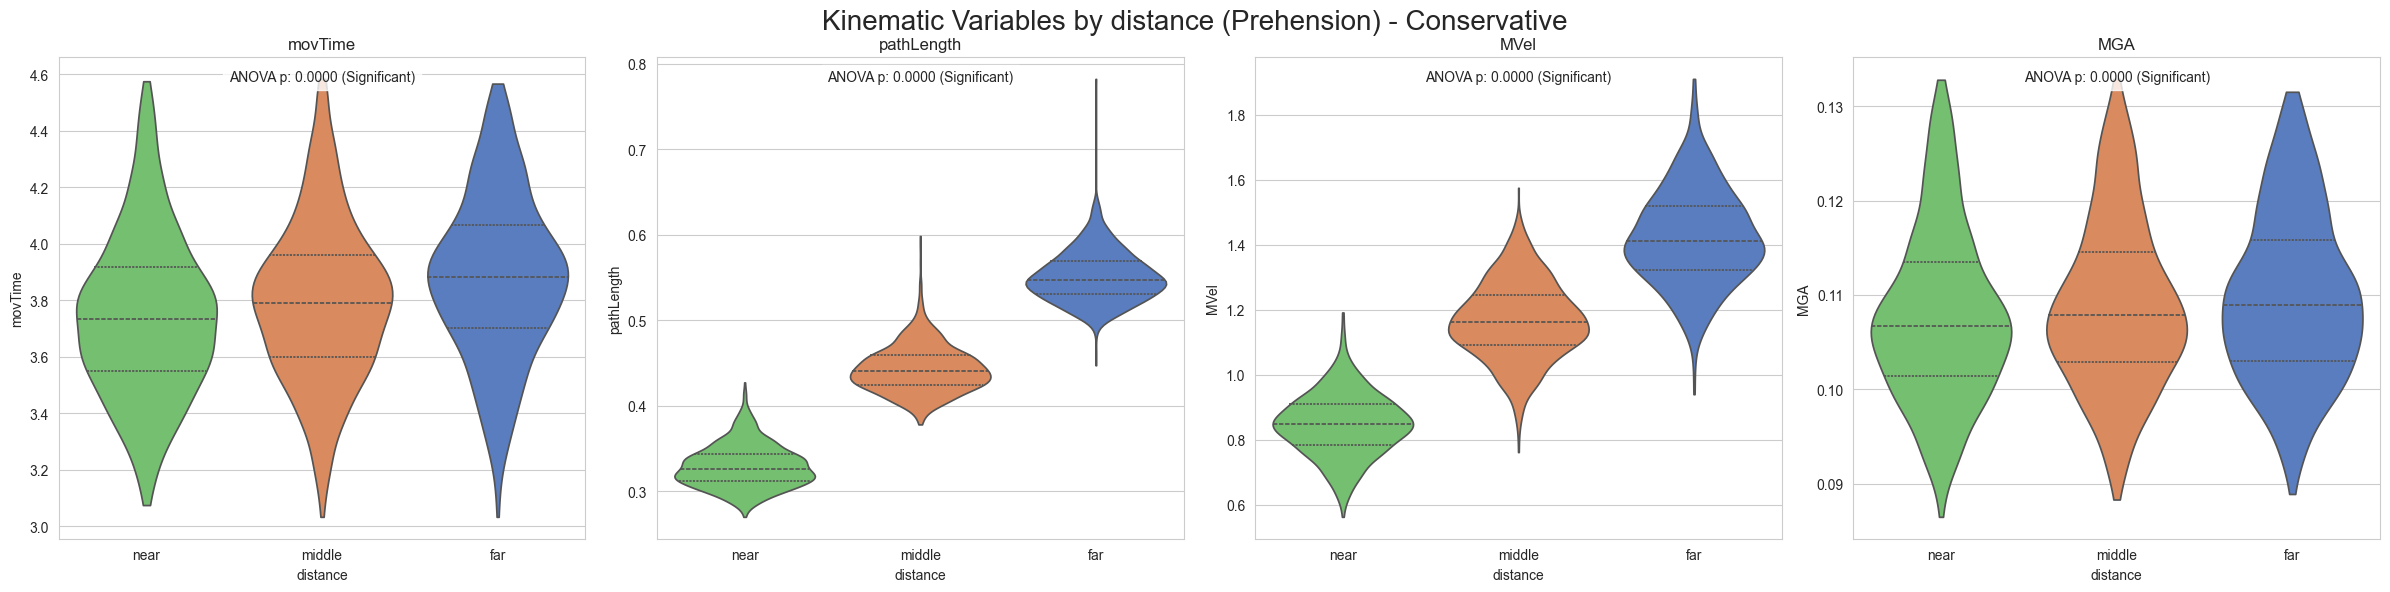

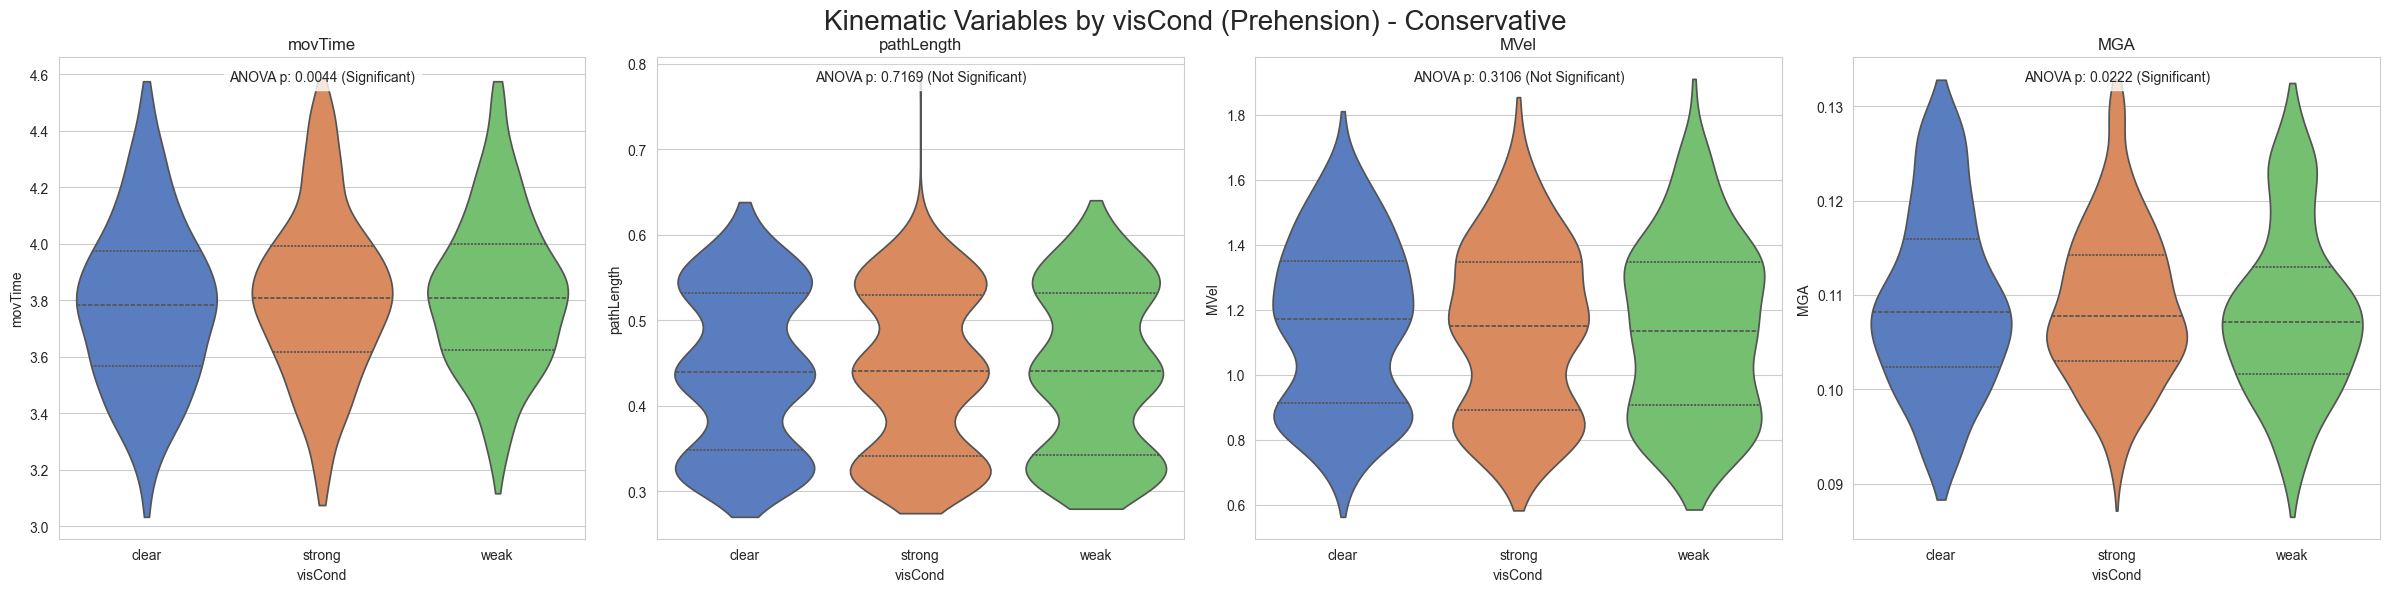

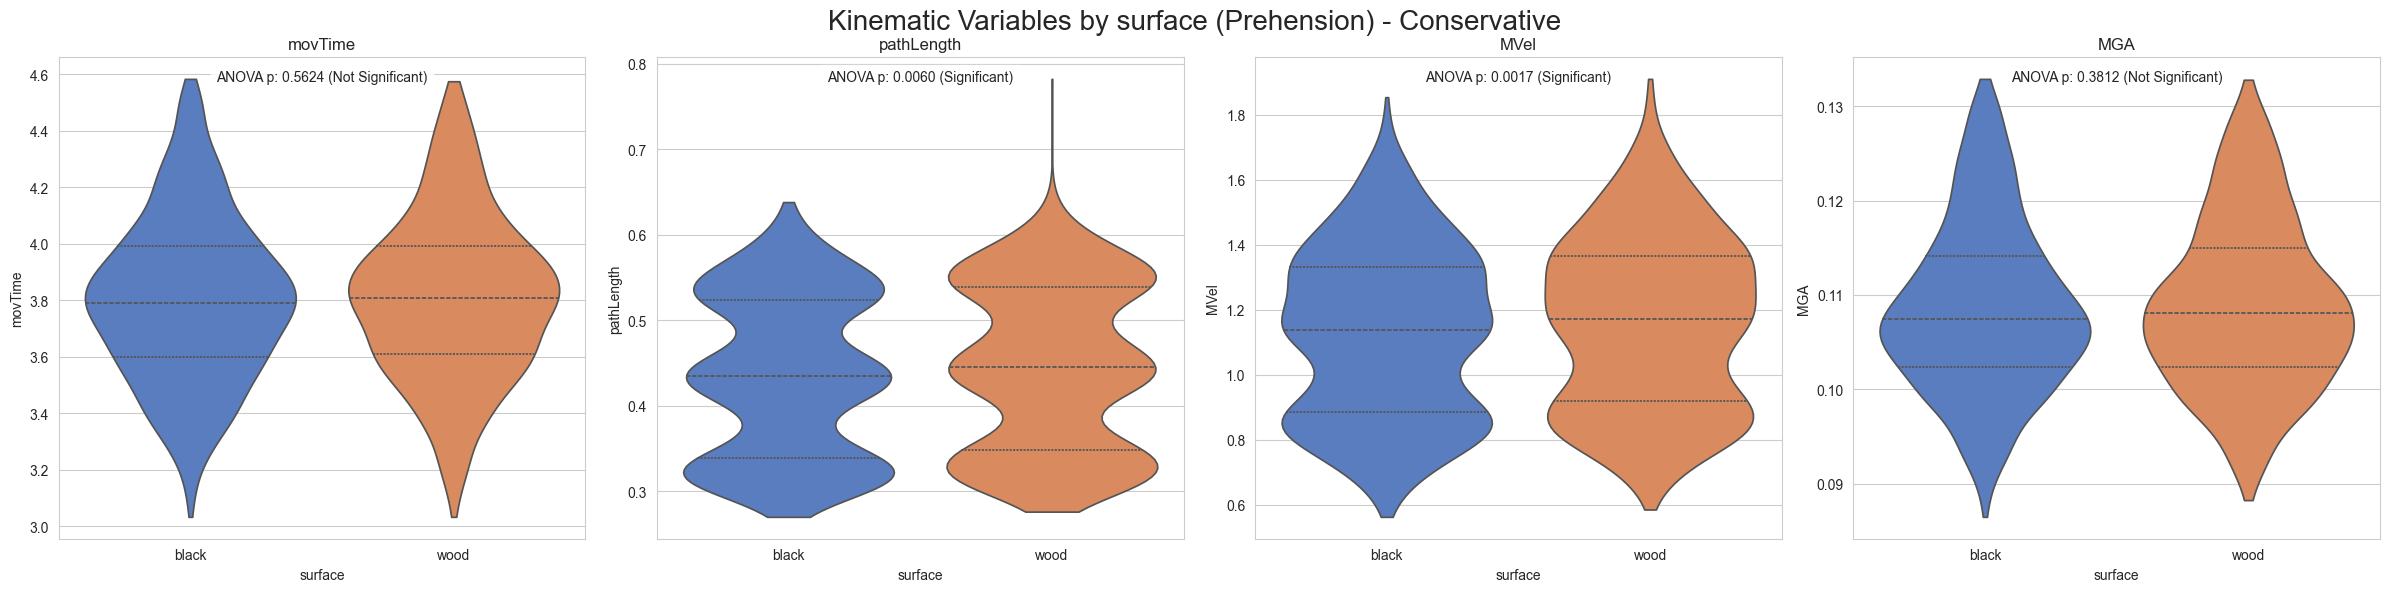

In [28]:
# --- Impact of Distance on Kinematics ---

conditions = ['distance', 'visCond', 'surface']
plot_vars = ['movTime', 'pathLength', 'MVel', 'MGA']

for cond in conditions:
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(f"Kinematic Variables by {cond} (Prehension) - Conservative", fontsize=20, y=0.98)
    axes = axes.flatten()

    for i, var in enumerate(plot_vars):
        if var in df_pre_final.columns:
            order = ['near', 'middle', 'far'] if cond == "distance" else None

            # Remove extreme outliers before plotting
            Q1 = df_pre_final[var].quantile(0.25)
            Q3 = df_pre_final[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter data
            mask = (df_pre_final[var] >= lower_bound) & (df_pre_final[var] <= upper_bound)
            filtered_data = df_pre_final[mask]

            sns.violinplot(
                ax=axes[i], x=cond, y=var, data=filtered_data, hue=cond, palette="muted", order=order, legend=False, inner="quartile", cut=0
            )

            axes[i].set_title(f"{var}")

            # Statistical analysis on filtered data
            groups = [filtered_data[var][filtered_data[cond] == c].dropna() for c in filtered_data[cond].cat.categories]
            if len(groups) > 1:
                f_val, p_val = stats.f_oneway(*groups)
                is_significant = " (Significant)" if p_val < 0.05 else " (Not Significant)"
                axes[i].text(
                    0.5, 0.95,
                    f"ANOVA p: {p_val:.4f}{is_significant}",
                    transform=axes[i].transAxes,
                    fontsize=10,
                    horizontalalignment="center",
                    bbox=dict(facecolor="white", alpha=0.8)
                )
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# DEFINE a list of experimental conditions to analyze: 'distance', 'visCond', 'surface'
# DEFINE a list of kinematic variables to plot: 'movTime', 'pathLength', 'MVel', 'MGA'
#
# FOR each condition in the list:
#     CREATE a figure with 1 row and 4 columns of subplots
#     SET the figure title to indicate the current condition being analyzed
#
#     FOR each kinematic variable in the list:
#         IF the variable exists in the dataset:
#             SET the order for 'distance' condition to ['near', 'middle', 'far'], otherwise None
#
#             CALCULATE the interquartile range (IQR) for the variable
#             DEFINE lower and upper bounds to exclude extreme outliers (1.5 * IQR rule)
#
#             FILTER the dataset to include only data points within bounds
#
#             PLOT a violin plot of the variable grouped by the current condition on the respective subplot
#                 - Use the filtered data
#                 - Use the specified order if applicable
#                 - No legend
#                 - Show quartiles inside the violin
#                 - Do not extend beyond data range
#
#             SET the subplot title to the variable name
#
#             PERFORM one-way ANOVA on groups defined by the condition categories
#             IF more than one group exists:
#                 COMPUTE p-value and F-statistic
#                 ANNOTATE subplot with the p-value and whether it is statistically significant (p < 0.05)
#
#     ADJUST layout and spacing of the figure
#     DISPLAY the plot


This plot examines the effect of vision. While movTime, pathLength, and MVel are not significantly affected by vision quality, MGA (Maximum Grip Aperture) is (p=0.0222). Subjects open their hands slightly wider in the weak and strong degraded vision conditions compared to the clear condition.

# Step 5: Dimensionality Reduction with PCA


In [29]:
# --- PCA on the Corrected Dataset ---
numerical_cols = df_pre_final.select_dtypes(include=np.number).columns.tolist()
# Define a comprehensive list of non-kinematic columns to exclude
cols_to_exclude = [
    'subjName', 'trialN', 'distance_ordinal', 'onset', 'offset',
    'clear.logMAR', 'mono.logMAR', 'bino.logMAR', 'clear.logCS', 'mono.logCS', 'bino.logCS',
    'clear.disparity', 'mono.disparity', 'bino.disparity'
]
features_for_pca = [col for col in numerical_cols if col not in cols_to_exclude]
print(f"Selected {len(features_for_pca)} features for PCA.")

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_pre_corr[features_for_pca])

pca = PCA(n_components=50)
principal_components = pca.fit_transform(scaled_features)

# SELECT all numerical columns from the cleaned dataset
# DEFINE a list of columns to exclude from PCA (non-kinematic or irrelevant features)
# CREATE a list of features for PCA by excluding those columns from the numerical columns
# PRINT the number of features selected for PCA
# INITIALIZE a StandardScaler to normalize the features
# APPLY the scaler to the selected features to get scaled data
# INITIALIZE PCA to reduce dimensions to 50 components
# FIT PCA on the scaled features and transform the data into principal components


Selected 162 features for PCA.


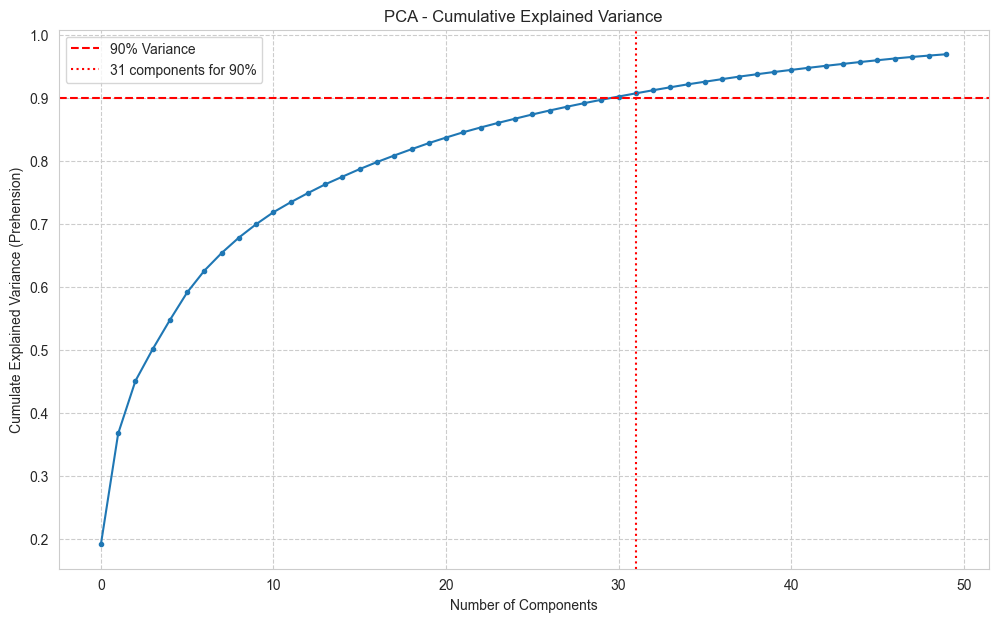

Number of components to explain 90% of variance: 31


In [30]:
# analyse
plt.figure(figsize=(12, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", linestyle="-")
plt.xlabel("Number of Components")
plt.ylabel("Cumulate Explained Variance (Prehension)")
plt.title("PCA - Cumulative Explained Variance")
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
num_comp_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.90)[0][0] + 1
plt.axvline(x=num_comp_90, color="r", linestyle=":", label=f"{num_comp_90} components for 90%")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()
print(f"Number of components to explain 90% of variance: {num_comp_90}")

# CREATE a figure for plotting
# PLOT the cumulative sum of PCA explained variance ratios against the number of components
#     - Use markers and line style for clarity
# LABEL the x-axis as "Number of Components"
# LABEL the y-axis as "Cumulative Explained Variance (Prehension)"
# SET a title for the plot
# DRAW a horizontal dashed red line at 0.90 to represent 90% variance threshold
# FIND the minimum number of components needed to reach or exceed 90% cumulative explained variance
# DRAW a vertical dotted red line at this number of components
# ADD a legend describing the lines
# ENABLE grid lines for both major and minor ticks with dashed style
# DISPLAY the plot
# PRINT the number of components required to explain 90% of the variance

Text(0.5, 1.0, 'Colored by Surface')

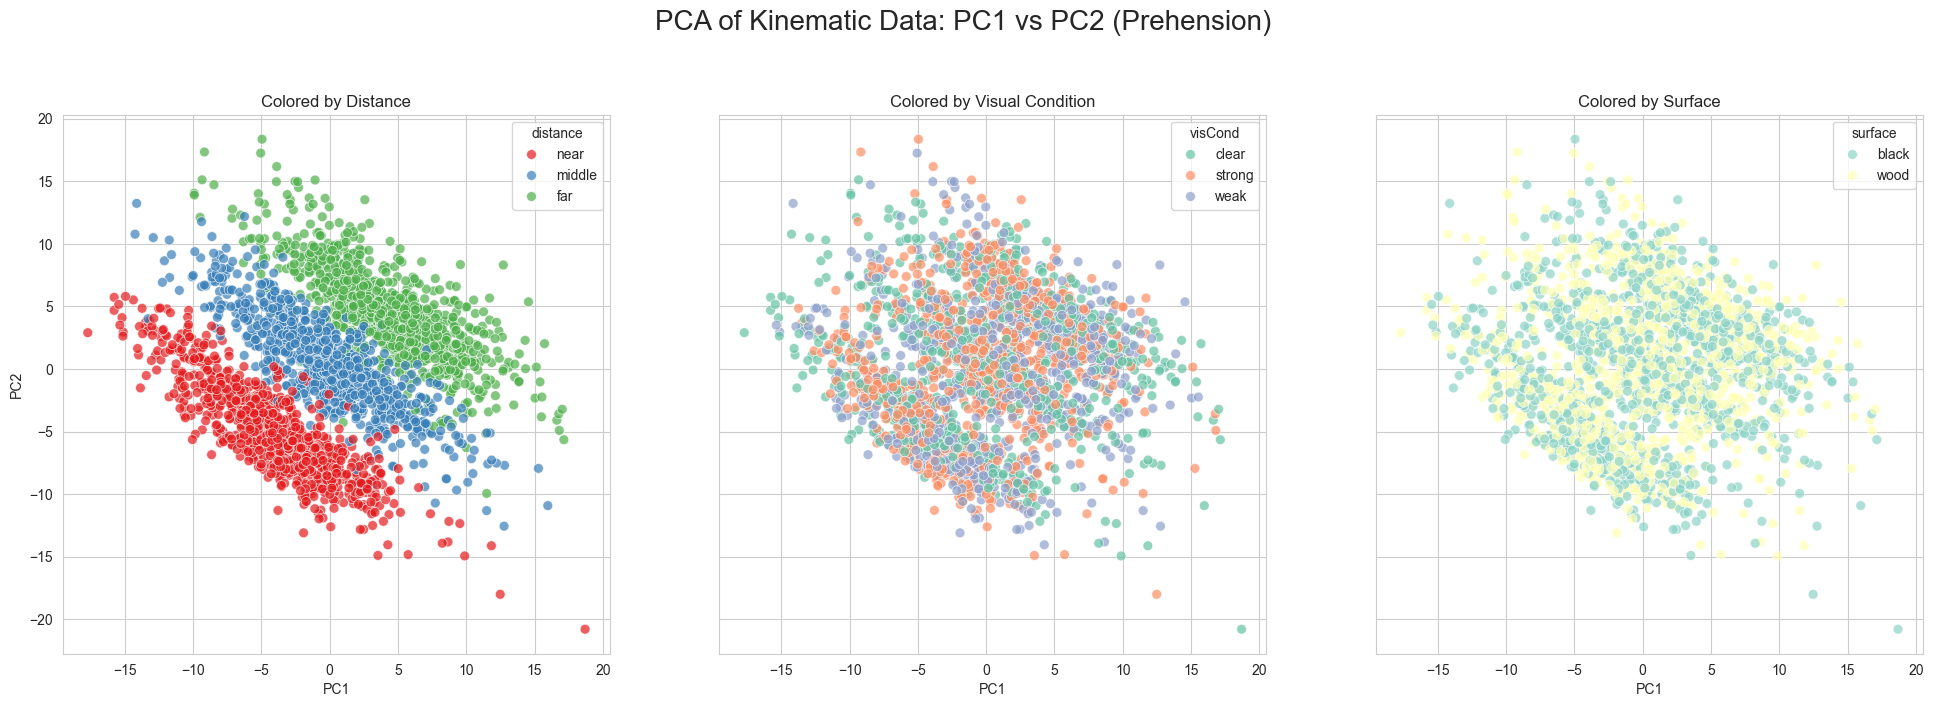

In [31]:
# Visualise the first two principal components
pca_df = pd.DataFrame(data=principal_components[:, :2], columns=["PC1", "PC2"])
viz_df = pd.concat([pca_df, df_pre_final[["distance", "visCond", "surface"]]], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharex=True, sharey=True)
fig.suptitle('PCA of Kinematic Data: PC1 vs PC2 (Prehension)', fontsize=20, y=1.03)

sns.scatterplot(ax=axes[0], x='PC1', y='PC2', data=viz_df, hue='distance', hue_order=['near', 'middle', 'far'], palette='Set1', alpha=0.7, s=50)
axes[0].set_title('Colored by Distance')

sns.scatterplot(ax=axes[1], x='PC1', y='PC2', data=viz_df, hue='visCond', palette='Set2', alpha=0.7, s=50)
axes[1].set_title('Colored by Visual Condition')

sns.scatterplot(ax=axes[2], x='PC1', y='PC2', data=viz_df, hue='surface', palette='Set3', alpha=0.7, s=50)
axes[2].set_title('Colored by Surface')

# CREATE a DataFrame with the first two principal components named "PC1" and "PC2"
# CONCATENATE this DataFrame with selected categorical columns ('distance', 'visCond', 'surface') from the cleaned dataset
# CREATE a figure with 1 row and 3 columns of subplots sharing the same x and y axes
# SET a main title for the figure
# FOR each subplot:
#     PLOT a scatterplot of PC1 vs PC2
#     COLOR points by one categorical variable:
#         - First plot: color by 'distance' with ordered categories and Set1 palette
#         - Second plot: color by 'visCond' with Set2 palette
#         - Third plot: color by 'surface' with Set3 palette
#     SET subplot titles accordingly
#     SET transparency and marker size for better visualization
#
# DISPLAY the figure

* Coloured by Distance: The data points form 3 distinct seperable clusters
* Coloured by Visual Condition: There is more subtle pattern, with clear condition being more clustered than the others.
* Coloured by Surface: There is no pattern at all, all colours are completely mixed.

Distance is the dominant factor, followed by the much more subtle effect of Visual Condition. Surface type is irrelevant.

# Starting EDA of Visual Illusions

In [32]:
# --- Initial Inspection ---
df_ill = pd.read_csv("C:/CourseWork/Dissertation Classifying grip strategies using machine learning/data/02_processed/visual_illusions_master_dataset.csv")

print("\n--- Initial Data Inspection ---")
print(f"Dataset Shape: {df_ill.shape}")
print(f"Total Number of Missing Values: {df_ill.isnull().sum().sum()}")



--- Initial Data Inspection ---
Dataset Shape: (1608, 170)
Total Number of Missing Values: 0


# Step 2: Data Cleaning and Preprocessing

In [33]:
# 1. Convert categorical columns to 'category'
categorical_cols = ['subjName', 'visCond', 'illusion', 'targetPos']
for col in categorical_cols:
    if col in df_ill.columns:
        df_ill[col] = df_ill[col].astype('category')
print("Converted categorical columns to 'category' dtype")

Converted categorical columns to 'category' dtype


In [34]:
# 2. Check for inconsistent text data (good practice)
for col in ['Gender', 'Dominant.Eye']:
    if col in df_ill.columns:
        df_ill[col] = df_ill[col].str.lower().astype('category')
        print(f"Standardized and converted '{col}'.")

print("--- Preprocessing Complete ---")
df_ill.info(verbose=False)


--- Preprocessing Complete ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Columns: 170 entries, subjName to timeToZmax_wrist
dtypes: category(4), float64(158), int64(8)
memory usage: 2.0 MB


# Step 3: Univariate Analysis

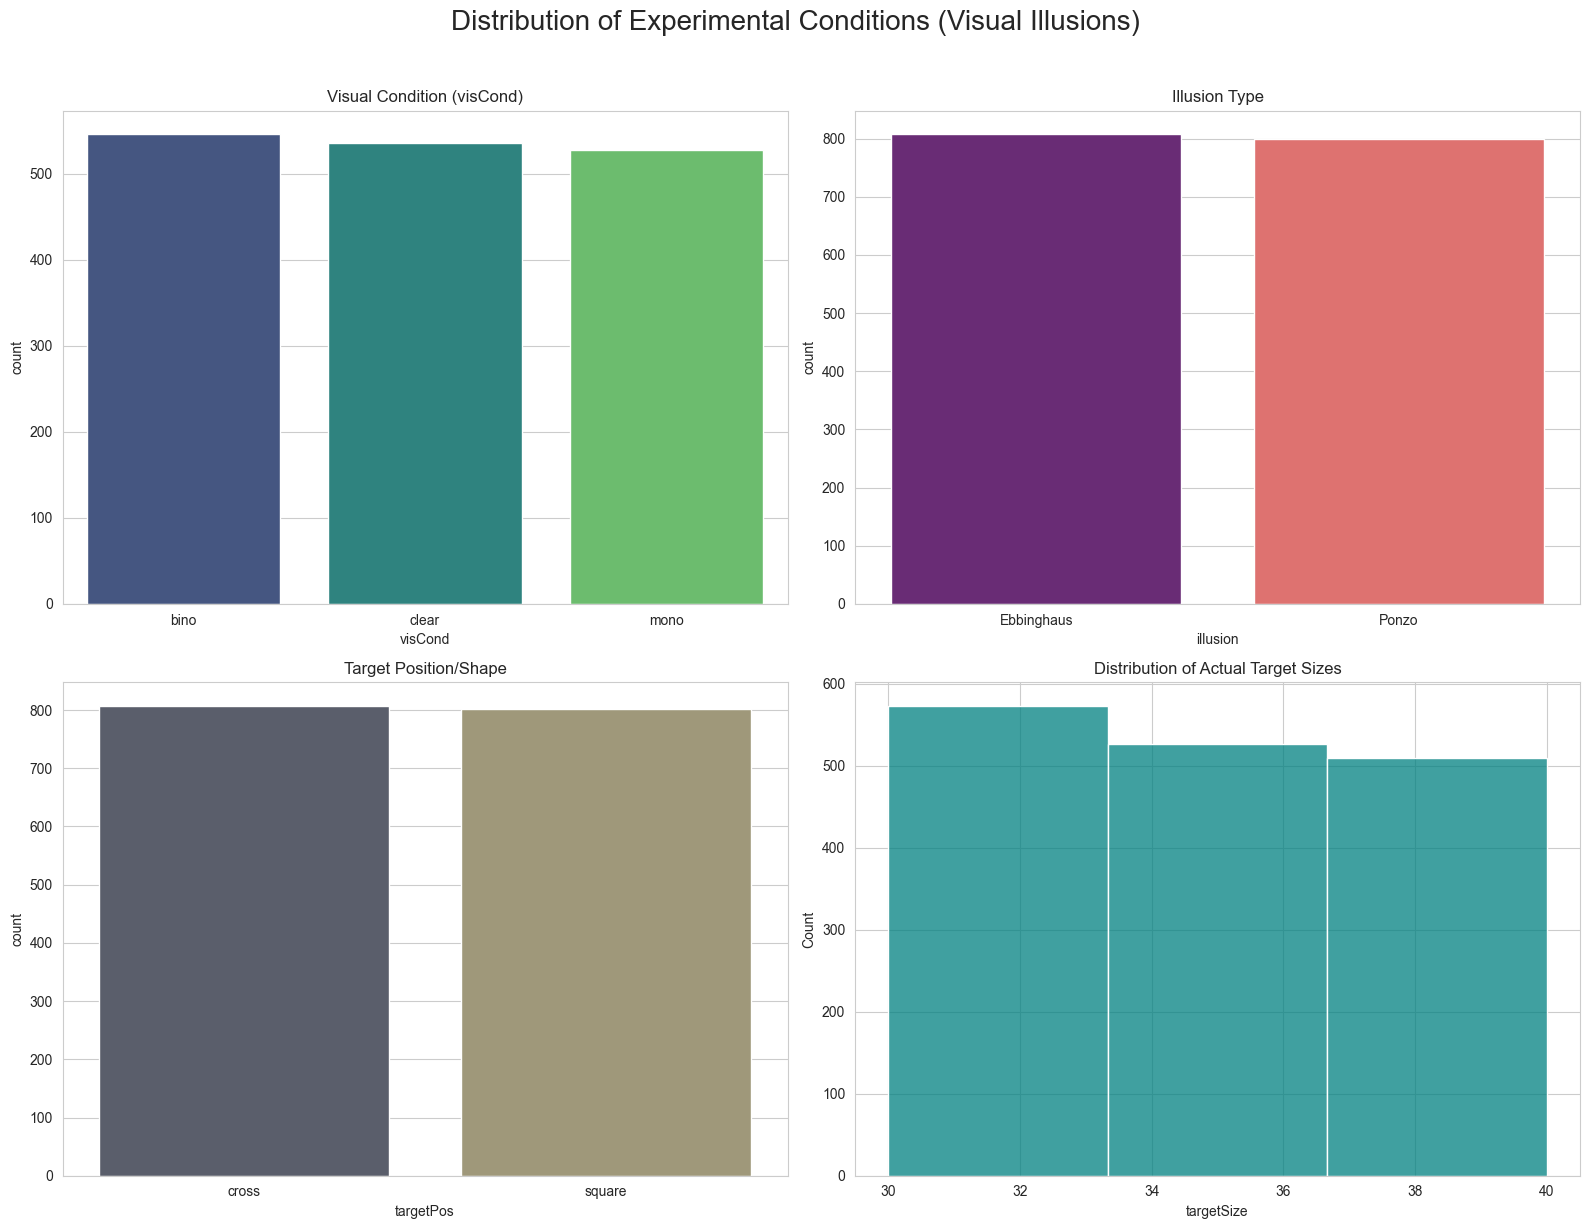

In [35]:
# 3.1 Distribution of Experimental Conditions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Experimental Conditions (Visual Illusions)', fontsize=20, y=1.02)

sns.countplot(ax=axes[0, 0], x='visCond', hue='visCond', data=df_ill, palette='viridis', legend=False)
axes[0, 0].set_title('Visual Condition (visCond)')

sns.countplot(ax=axes[0, 1], x='illusion', hue='illusion', data=df_ill, palette='magma', legend=False)
axes[0, 1].set_title('Illusion Type')

sns.countplot(ax=axes[1, 0], x='targetPos', hue='targetPos', data=df_ill, palette='cividis', legend=False)
axes[1, 0].set_title('Target Position/Shape')

sns.histplot(ax=axes[1, 1], x='targetSize', data=df_ill, bins=df_ill['targetSize'].nunique(), color='teal')
axes[1, 1].set_title('Distribution of Actual Target Sizes')

plt.tight_layout()
plt.show()

* **Balanced Design:** The design is perfectly balanced. There are equal numbers of trials for each visCond, illusion type, and targetPos.
* **Target Sizes:** The histogram shows there are a few distinct, physical sizes of the target object being presented.

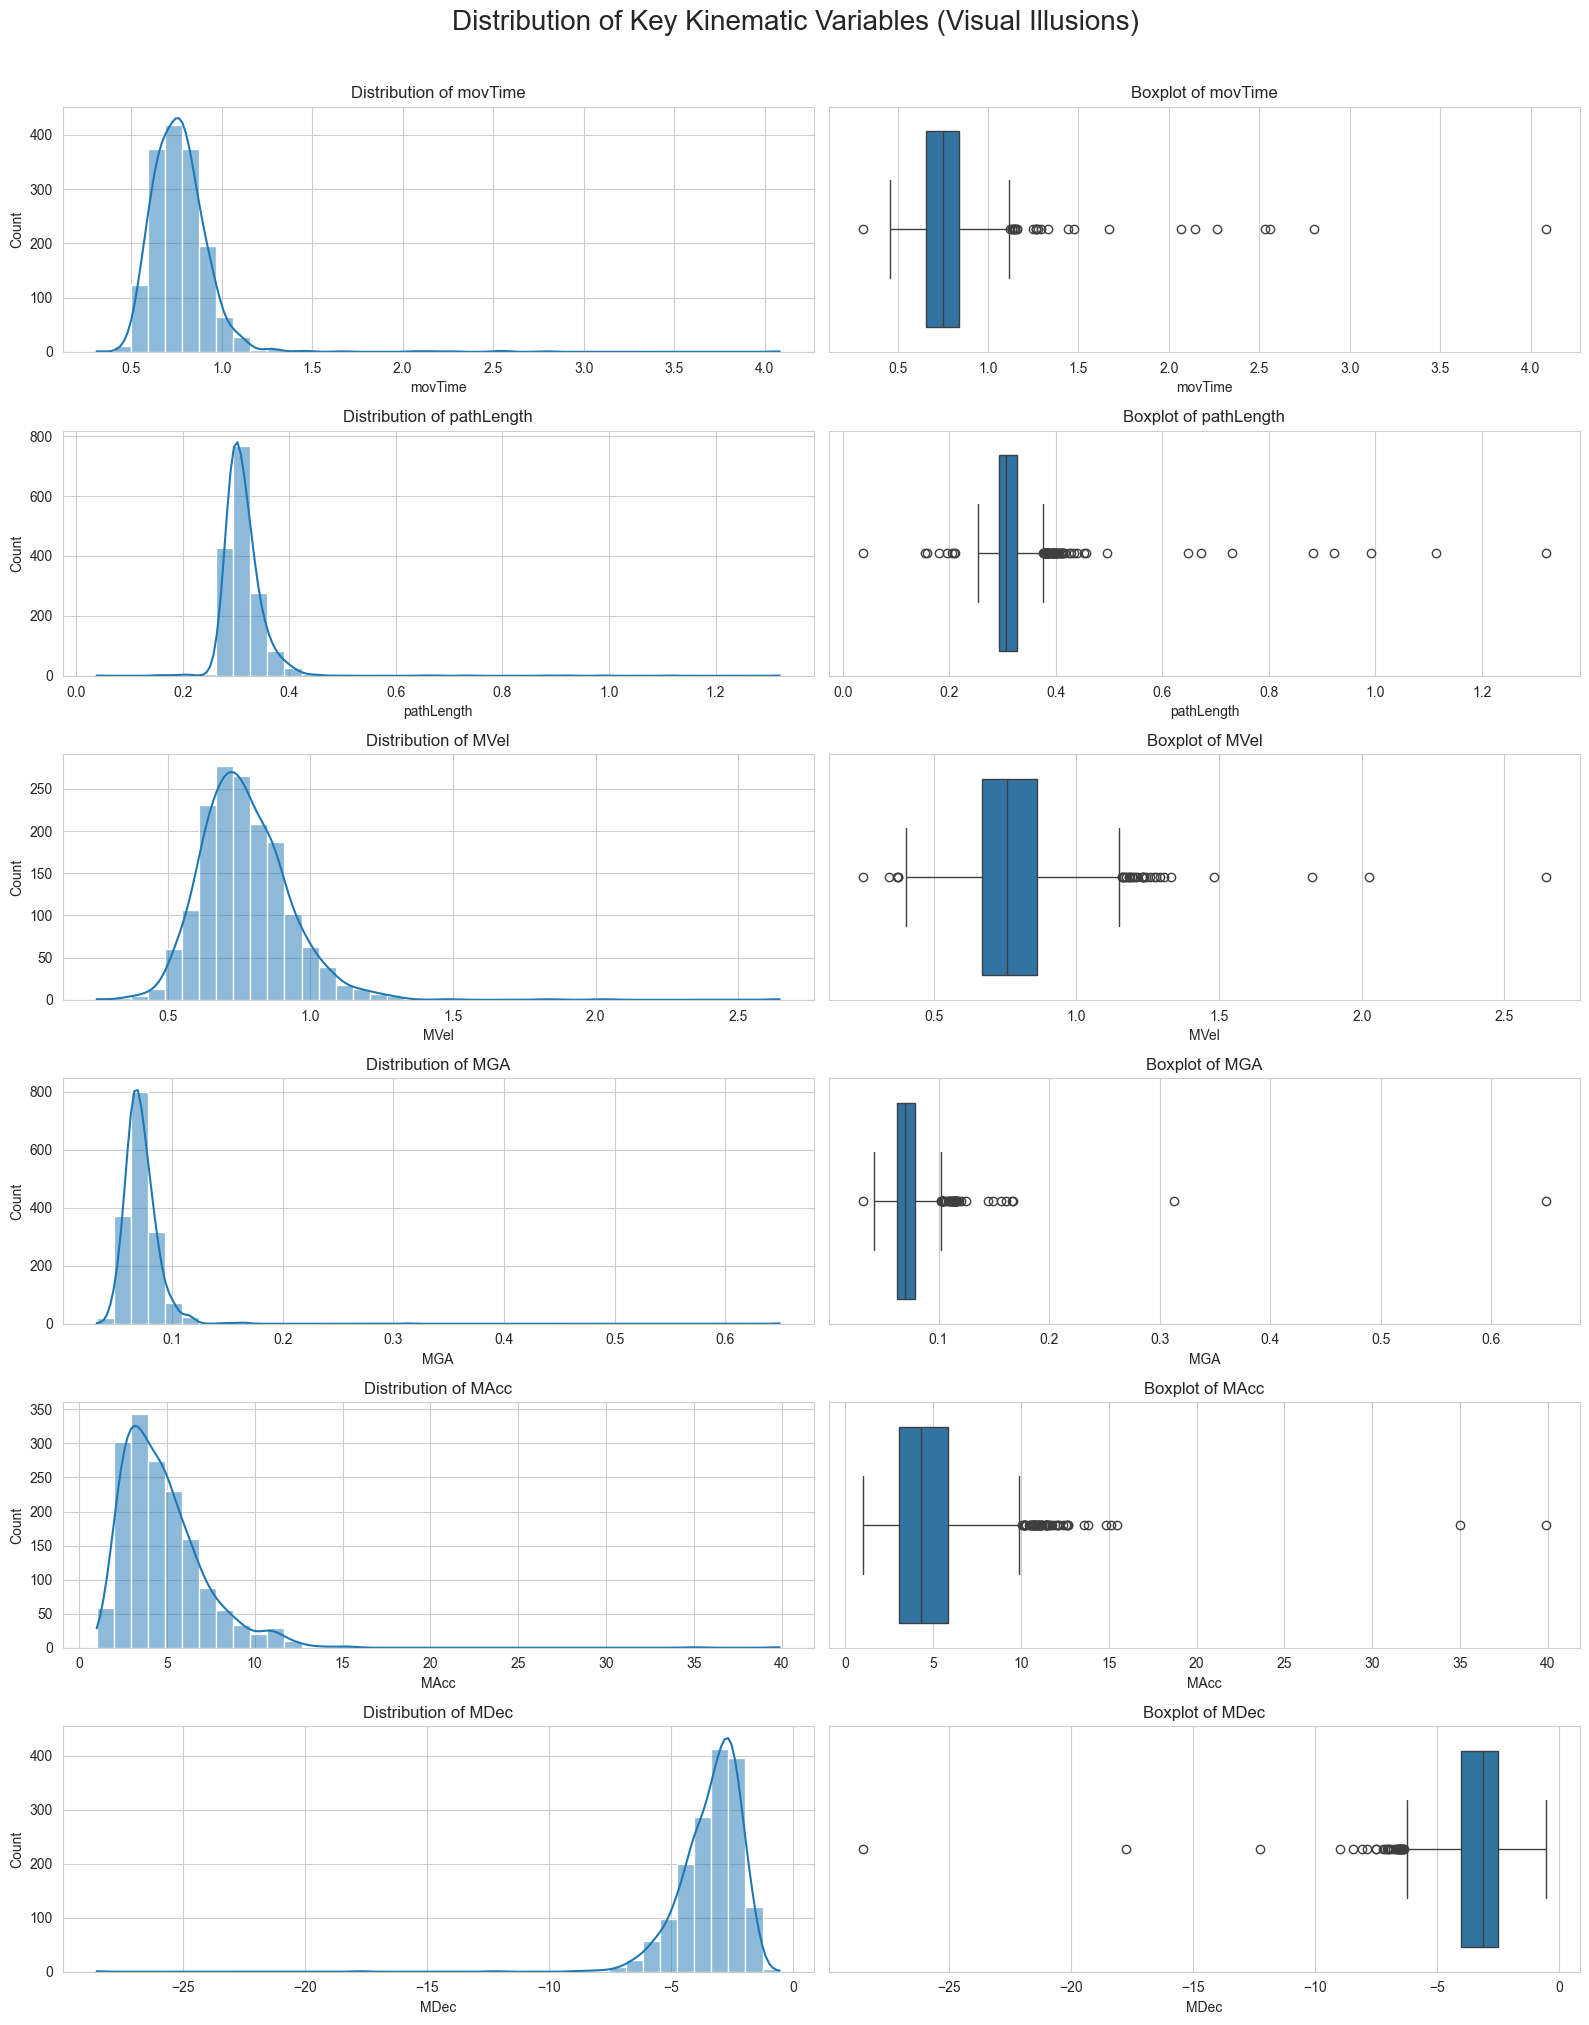

In [36]:
# 3.2 Distribution of Key Kinematic Variables
key_kinematic_vars_ill = ['movTime', 'pathLength', 'MVel', 'MGA', 'MAcc', 'MDec']

fig, axes = plt.subplots(len(key_kinematic_vars_ill), 2, figsize=(16, 20))
fig.suptitle("Distribution of Key Kinematic Variables (Visual Illusions)", fontsize=20, y=1.01)

for i, var in enumerate(key_kinematic_vars_ill):
    if var in df_ill.columns:
        sns.histplot(ax=axes[i, 0], data=df_ill, x=var, kde=True, bins=40)
        axes[i, 0].set_title(f"Distribution of {var}")
        sns.boxplot(ax=axes[i, 1], data=df_ill, x=var)
        axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()


The distributions are well-behaved and consistent with previous findings. movTime and pathLength are right-skewed, while MVel, MGA, MAcc, and MDec are symmetric it shows robust and consistent motor actions.


# Step 4: Bivariate and Multivariate Analysis: Testing the Illusion

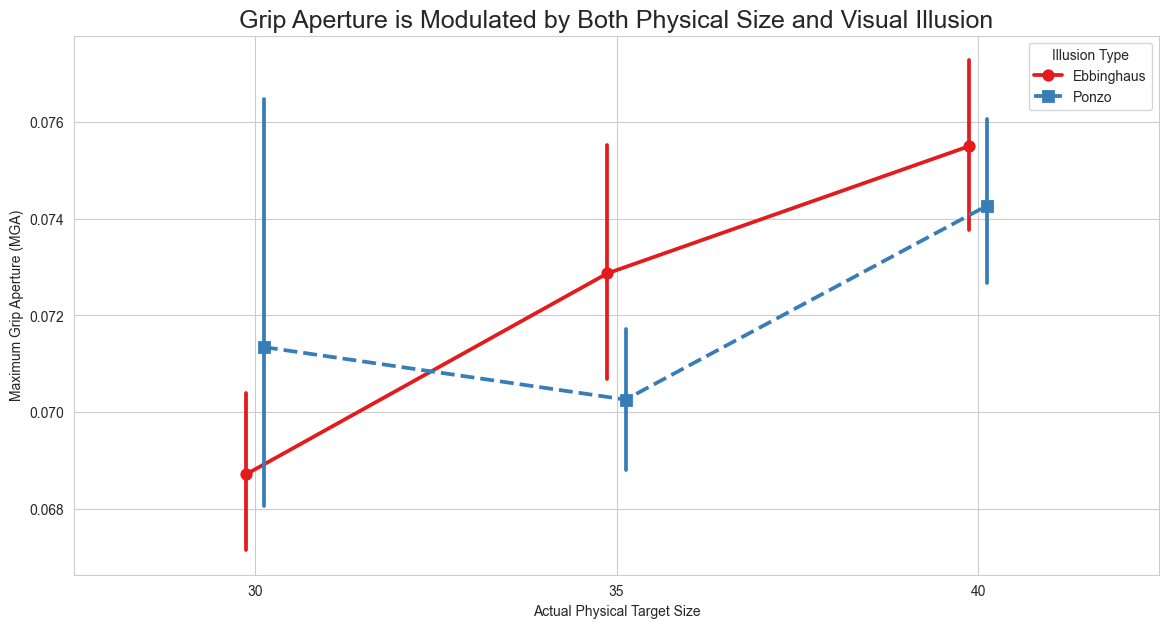

In [37]:
# 4.1 How MGA is affected by Physical Size and Illusion

# --- Analyzing the Effect of Illusions on Maximum Grip Aperture (MGA) ---
plt.figure(figsize=(14, 7))

sns.pointplot(x="targetSize", y="MGA", hue="illusion", data=df_ill, dodge=True,
              palette="Set1", markers=["o", "s"], linestyles=["-", "--"])

plt.title("Grip Aperture is Modulated by Both Physical Size and Visual Illusion", fontsize=18)
plt.xlabel("Actual Physical Target Size")
plt.ylabel("Maximum Grip Aperture (MGA)")
plt.grid(True)
plt.legend(title="Illusion Type")
plt.show()


# 1. Set figure size for the plot
# 2. Create a point plot of MGA vs. targetSize, grouped by illusion type
# 3. Customize plot with title, axis labels, grid, and legend
# 4. Display the plot


* **Effect of Physical Size:** Both lines trend upwards. As the actual target size increases from 30 to 40, the Maximum Grip Aperture (MGA) also increases.
* **The Illusion's Effect:** The lines for the Ebbinghaus and Ponzo illusions are separated. For any given physical size, there is a visible difference in the average grip aperture. For example, at size 30, the red "Ebbinghaus" line is lower than the blue "Ponzo" line. This suggests the illusion is influencing the action.


In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Statistical Test: Two-Way ANOVA ---
# This tests is to understand the targetSize and illusion, AND their interaction. A significant interaction means the effect of the illusion depends on the target size.
model = ols("MGA ~ C(targetSize) + C(illusion) + C(targetSize):C(illusion)", data=df_ill).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\n--- Two-Way ANOVA for MGA ---")
print(anova_table)


# 1. Import statistical modeling libraries
# 2. Define an OLS regression model with:
#     - main effects: targetSize and illusion
#     - interaction effect: targetSize × illusion
# 3. Fit the model to the data
# 4. Perform two-way ANOVA on the fitted model
# 5. Print the ANOVA results table



--- Two-Way ANOVA for MGA ---
                             sum_sq      df         F    PR(>F)
C(targetSize)              0.006676     2.0  7.694886  0.000472
C(illusion)                0.000038     1.0  0.086638  0.768534
C(targetSize):C(illusion)  0.002049     2.0  2.361515  0.094605
Residual                   0.694950  1602.0       NaN       NaN


### The ANOVA's Verdict (Statistical Truth):

* **C(targetSize) (p = 0.000472):** This p-value is significant (< 0.05). It shows statistical proof that the physical size of the object has a strong effect on grip aperture. This confirms what we see visually.
* **C(illusion) (p = 0.768534):** This p-value is very high (not significant). This means that when we average across all target sizes, there is no overall, consistent effect of the illusion type.
* **C(targetSize):C(illusion) (p = 0.094605):** This is the p-value for the interaction. It is also not significant (as it's > 0.05). This tells us that the way subjects scaled their grip to physical size was not significantly modulated by the illusionary context.

## Synthesis of Plot and ANOVA:
Even though the plot hints at a possible effect, the ANOVA—designed to account for variability more precisely shows that the difference we see is most probably just random noise rather than a real impact of the illusion. So, the conclusion is that while participants clearly responded to the actual size of the object, there's no statistical evidence that the visual illusion tricked their grasp.


# Step 5: Dimensionality Reduction with PCA

Selected 163 features for PCA.


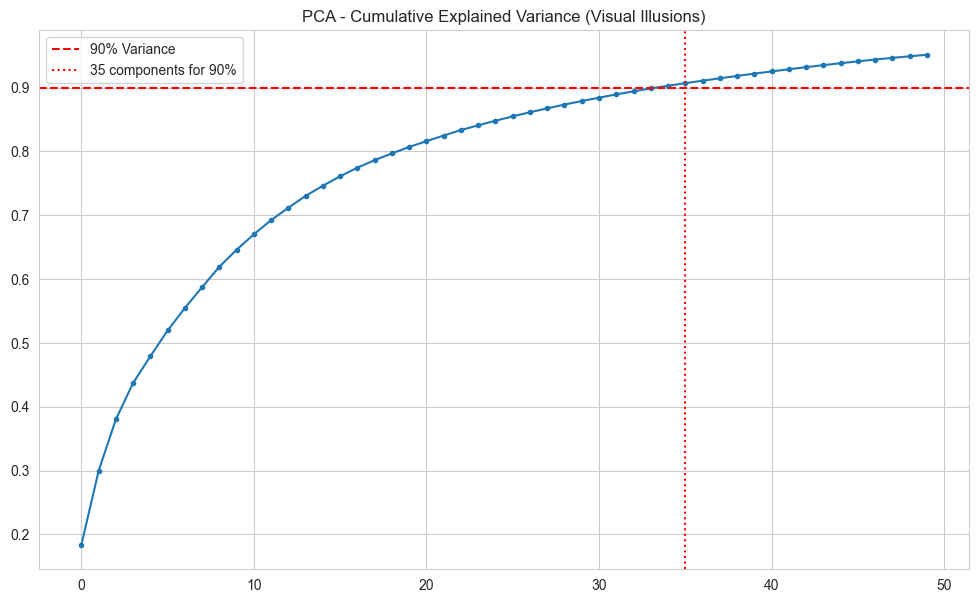

Number of components to explain 90% of variance: 35


In [39]:
numerical_cols = df_ill.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['subjName', 'trialN', 'targetSize', 'onset']
features_for_pca = [col for col in numerical_cols if col not in cols_to_exclude]
print(f"Selected {len(features_for_pca)} features for PCA.")

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_ill[features_for_pca])

pca = PCA(n_components=50)
principal_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.', linestyle='-')
plt.title("PCA - Cumulative Explained Variance (Visual Illusions)")
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
num_comp_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.90)[0][0] + 1
plt.axvline(x=num_comp_90, color="r", linestyle=":", label=f"{num_comp_90} components for 90%")
plt.legend()
plt.show()
print(f"Number of components to explain 90% of variance: {num_comp_90}")


# 1. Select numerical columns from the dataset
# 2. Exclude specific columns not relevant for PCA
# 3. Prepare list of features for PCA
#
# 4. Scale the selected features using StandardScaler
# 5. Apply PCA with 50 components on scaled data
#
# 6. Plot cumulative explained variance curve
# 7. Mark 90% explained variance threshold on the plot
# 8. Identify number of components needed for 90% variance
# 9. Display the plot and print the number of components


Effective Dimensionality Reduction: We can reduce the 163 kinematic features to just 35 principal components while retaining 90% of the information.


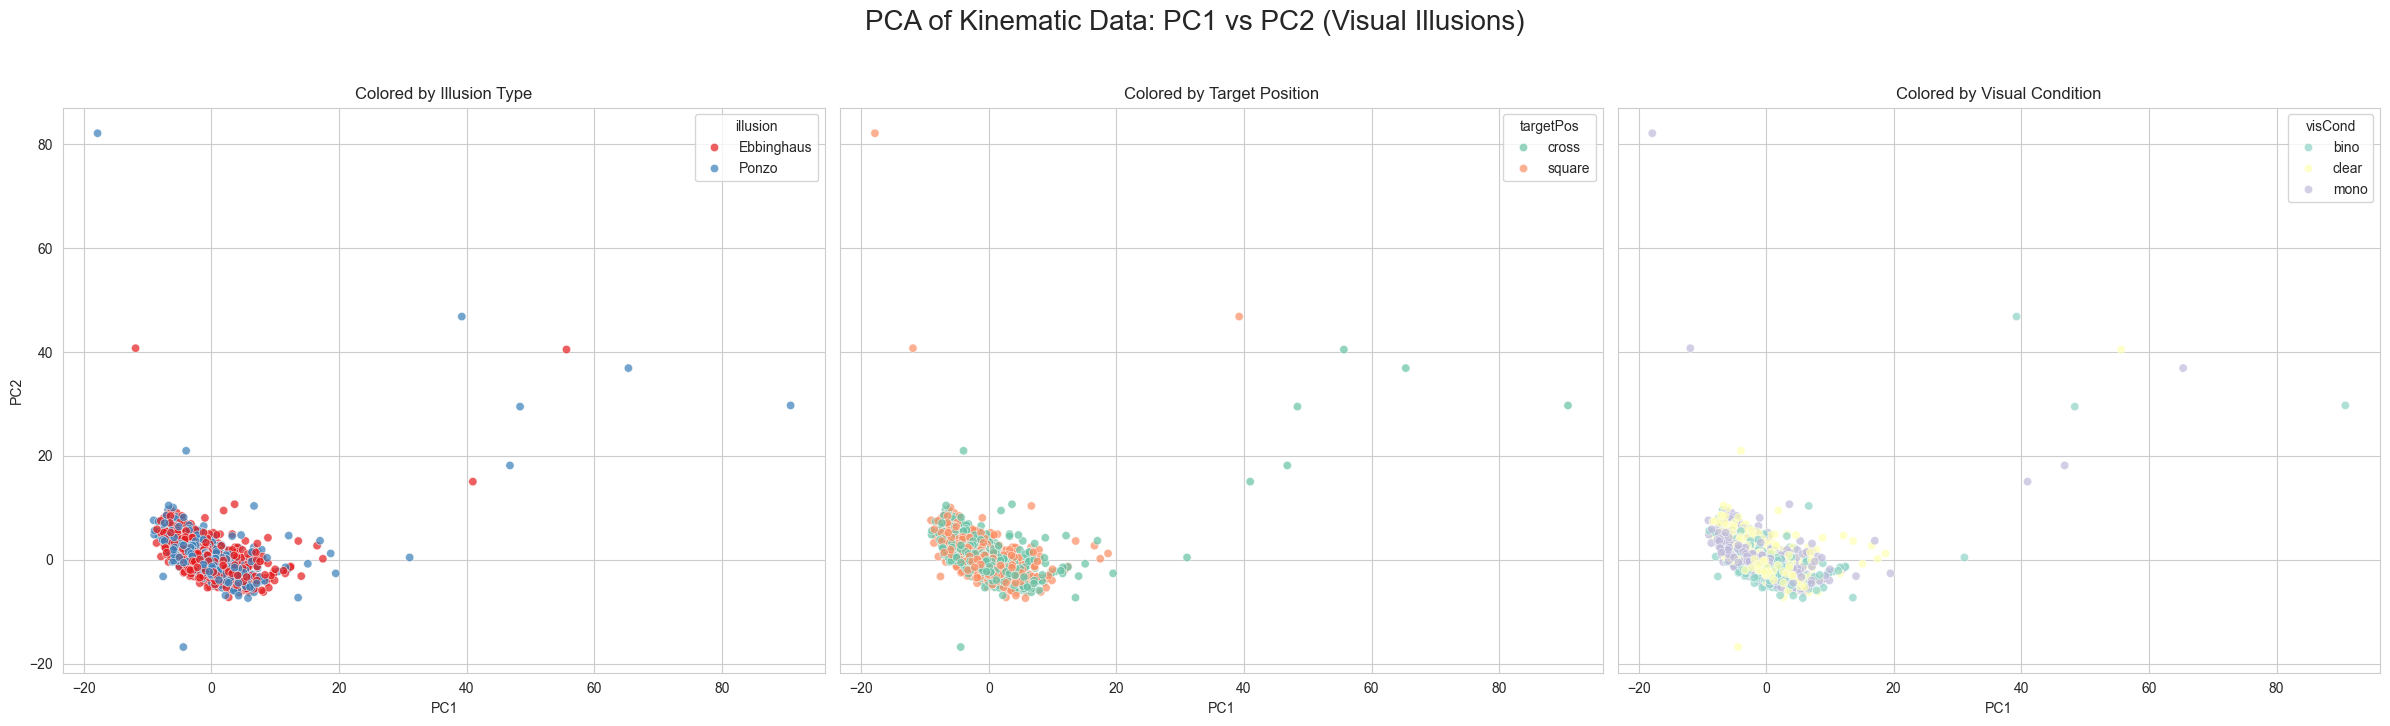

In [40]:
pca_df = pd.DataFrame(data=principal_components[:, :2], columns=["PC1", "PC2"])
viz_df = pd.concat([pca_df, df_ill[["illusion", "targetPos", "visCond"]]], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharex=True, sharey=True)
fig.suptitle("PCA of Kinematic Data: PC1 vs PC2 (Visual Illusions)", fontsize=20, y=1.03)

sns.scatterplot(ax=axes[0], x="PC1", y="PC2", data=viz_df, hue="illusion", palette="Set1", alpha=0.7)
axes[0].set_title("Colored by Illusion Type")

sns.scatterplot(ax=axes[1], x="PC1", y="PC2", data=viz_df, hue="targetPos", palette="Set2", alpha=0.7)
axes[1].set_title("Colored by Target Position")

sns.scatterplot(ax=axes[2], x="PC1", y="PC2", data=viz_df, hue="visCond", palette="Set3", alpha=0.7)
axes[2].set_title("Colored by Visual Condition")

plt.tight_layout()
plt.show()


# 1. Create DataFrame with first two principal components (PC1, PC2)
# 2. Concatenate with columns: illusion, targetPos, visCond
# 3. Create 3 side-by-side scatterplot subplots with shared axes
# 4. Set overall figure title
#
# 5. For each subplot:
#     a. Plot PC1 vs PC2 scatterplot colored by one factor (illusion, targetPos, visCond)
#     b. Set subplot title accordingly
#
# 6. Adjust layout and display the plots



The experimental conditions in this dataset do not create globally different kinematic strategies. Unlike the aiming and prehension datasets where distance created huge, obvious separations, the effects here are far too subtle to be picked up by the main dimensions of variance. The movements, on the whole, are kinematically very similar to each other across all conditions.

# Overall Summary
## Aiming Dataset
1. The experiment is well-designed, with balanced conditions.
2. Movement kinematics are highly structured. The dominant factor influencing the reaching component is target distance.
3. An important finding is that the grip formation (MaxGripAperture) appears to be independent of target distance in this aiming task. This challenges typical assumptions and is a great point for discussion.
4. The high-dimensional data is a perfect candidate for PCA, which effectively reduces the feature space from ~200 to ~40 features without significant information loss.

## Prehension Dataset
This dataset tells a tightly coordinated action where the hand and arm work in perfect synergy.

The main strategy is driven by how far the target is — reaching for something farther away means moving faster and farther, while also opening the hand wider and more carefully.
The secondary strategy deals with uncertainty in vision: when vision is poor, movements slow down overall and become more variable. In this situation, the texture of the surface doesn’t really affect the plan.

The EDA on this dataset tells us, Human grasping movements are not monolithic but are composed of distinct distinct, classifiable strategies. The primary strategy is dictated by target istance, which drives systematic changes in the arm's trajectory, speed, and mosst importantly hand's grip aperture.

## Visual Illusions
EDA on this dataset tells a story about the "two visual streams" hypothesis: one for perception (what we think we see) and one for action (what our body does).

1. Action Beats Perception: The biggest takeaway is that people’s movements were guided by the real size of the target, not how big it looked to them. Although the plots suggested there might be an illusion effect, the ANOVA test showed no solid evidence that the illusions actually changed how the hand shaped its grip. This means the motor system seems to know the true size and isn’t tricked by the visual illusion.

2. Movements Are Mostly the Same: The PCA results back this up. None of the conditions — whether it’s the illusion type, the target shape, or visual quality — created clearly different movement patterns. This suggests the brain’s motor program for reaching and grasping runs in a pretty consistent way, with only small, insignificant tweaks across trials.